<a href="https://colab.research.google.com/github/neuropoly/realtime-dynamic-shimming/blob/dynamic-shimming-in-the-cervical-SC-for-MGRE-at--3T/Dynamic_Shimming_in_the_Cervical_Spinal_Cord_for_Multi_Echo_Gradient_Echo_Imaging_at_3T_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Introduction

This notebook serves to reproduce the processing pipeline and visualisation for the following paper:
*E. Alonso-Ortiz et al: Dynamic Shimming in the Cervical Spinal Cord for Multi-Echo Gradient-Echo Imaging at 3 T*

It is broken into three main sections:

1, Setup, where the necessary toolboxes and python libraries are imported. Processing time is approximately 10 minutes.

2, Postprocessing: Registration, where the registration steps (MGRE-to-T1w and MGRE-to-PAM50) are performed. Processing time, exluding manual corrections, is approximately 6 hours.

3, Postprocessing: Statistics and visualisation, where the statistical tests and data visualisation is preformed. This step is set up to run independently, and to use the supplied, manually corrected data. Processing time is approximately 10 minutes. 

Note that manual correction is necessary in step 2 to correct the segmentation of the spinal cord. Within this notebook, this manual correction is omitted from step 2. 

The manually corrected data is supplied at the beginning of step 3, to enable a reproduction of the results in the paper.

Should the data provided at the beginning of step 2 (i.e. data that has *not* been manually corrected) be used in step 3 as well, the results may not be an exact match for those presented in the paper.

Daniel Papp, Eva Alonso-Ortiz

Polytechnique Montreal

2022

# Setup

Here, we import the necessary libraries and install the necessary toolboxes

In [ ]:
############ Importing libraries
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
import sys
import cv2
import re
import pandas as pd
from os.path import join
import glob
import zipfile
import shutil
import logging
import subprocess
import fnmatch
import pathlib
import json
import time
import seaborn as sns
import os
import scipy
from scipy import stats
from scipy.stats import mannwhitneyu
from statsmodels.stats.weightstats import ztest as ztest
from scipy.stats import bartlett
from scipy.stats import ansari
from scipy.stats import wilcoxon
from scipy.stats import kruskal
from scipy.stats import friedmanchisquare
from tabulate import tabulate

print('Necessary libraries imported')

In [ ]:
## Installing necessary tools

# OSFClient: this tool is used to download the compressed data from OSF
# Github: https://github.com/osfclient/osfclient
os.chdir('/content/')
! git clone https://github.com/osfclient/osfclient

% cd osfclient/ 

! pip install osfclient
print('OSF client installed')

# Spinal cord toolbox (SCT): This tool is used to for most of our processing, including image registration
# Website: https://spinalcordtoolbox.com/
# Github: https://github.com/spinalcordtoolbox/spinalcordtoolbox/
os.chdir('/content/')
!git clone --depth 1 --branch 5.3.0 https://github.com/spinalcordtoolbox/spinalcordtoolbox
% cd spinalcordtoolbox/
!yes | ./install_sct
os.environ['PATH'] += ':/content/spinalcordtoolbox/bin'
os.environ['SCT_DIR'] = '/content/spinalcordtoolbox'
print("Spinal cord toolbox installed")

# NIIMATH: since the sct_math function used in the "Registration to PAM50 template" is configured for 3D images, niimath
# is used to perform a few image operations on 4D images
# Github: https://github.com/rordenlab/niimath
os.chdir('/content/')
!curl -fLO https://github.com/rordenlab/niimath/releases/download/v1.0.20211212/niimath_lnx.zip
os.makedirs('/content/niimath/', exist_ok=True)
!unzip -o niimath_lnx.zip -d /content/niimath
os.environ['PATH'] += ':/content/niimath'
os.environ["FSLOUTPUTTYPE"] = 'NIFTI_GZ'
print("NIImath installed")
print("All necessary tools have been installed!")

In [ ]:
#Here, the various helper functions are defined
#run_subprocess is a wrapper for subprocess.run
def run_subprocess(cmd):
    """Wrapper for ``subprocess.run()`` that enables to input ``cmd`` as a full string (easier for debugging).
    Args:
        cmd (string): full command to be run on the command line
    """
    try:
        subprocess.run(
            cmd.split(' '),
            text=True,
            check=True
        )
    except subprocess.CalledProcessError as err:
        msg = "Return code: ", err.returncode, "\nOutput: ", err.stderr
        raise Exception(msg)

## Helper function for extracting the signal across the cord across slices for the PAM50 registered scans
import pandas as pd
def signal_extractor_for_PAM50(csv_filename):
  ## Load the CSV file into a Pandas DataFrame
  dataframe=pd.read_csv(csv_filename, index_col='Slice (I->S)')
  ## Convert all the strings (123.4242, etc) of the WA column into actual numerical values
  dataframe['WA()'] = pd.to_numeric(dataframe['WA()'], errors='coerce')
  nSlices=int(np.max(dataframe.index)+1)
  nEchoes=int(np.size(dataframe['WA()'])/nSlices)
  WA_matrix=dataframe['WA()'].to_numpy()
  WA_matrix=WA_matrix.reshape(nEchoes,nSlices)
  WA_matrix=WA_matrix[:,740:800] #Eg, where the values are non-zero
  return WA_matrix

def CoV_extractor_STD(csv_filename):
  dataframe_mean=pd.read_csv(csv_filename, index_col='Slice (I->S)')
  dataframe_mean['STD()'] = pd.to_numeric(dataframe_mean['STD()'], errors='coerce')
  STD_matrix=dataframe_mean['STD()'].to_numpy()
  return STD_matrix

# Postprocessing: Registration 

##Downloading data

In [ ]:
# Downloading data
os.chdir('/content/osfclient/')
! osf -p v4tdk fetch /Paper/SC_rt_shim.zip /content/osfclient/SC_rt_shim.zip
print("Data suscesfully downloaded")
zipped_nifti='/content/osfclient/SC_rt_shim.zip'
with zipfile.ZipFile(zipped_nifti,"r") as zip_ref:
  zip_ref.extractall('/content/')
# clearing up annoying _MACOSX directory
shutil.rmtree('/content/__MACOSX')
print("Unzipping done")

100% 181M/181M [00:01<00:00, 113Mbytes/s]
Data suscesfully downloaded
Unzipping done


##Registration of the T1w segmentation onto the MGRE scans

Here we supply the manually corrected segmentation for T1w scans. 

Then, the MGRE scans are registered to the T1w scans (MGRE-to-T1w), and the inverse of this registration (the T1w-to-MGRE warp filed) is used to register the segmentation of the T1w scans into the MGRE space.

This registered segmentation requires manual correction, which is not possible within this notebook, and would require manual download of the data. 

In [ ]:
## Within this step, we apply the T1w segmentation to the MGRE scans
# We first register the MGRE scans to the T1w scan, and then apply the inverse of
# this transformation to the segmentation, thereby moving the spinal cord
# segmentation of the T1w scan to the space of the MGRE scans correspoding to the
# five shimming conditions 

Subjectdirs=sorted(glob.glob('/content/SC_rt_shim/'+'*acdc*')) ##Finding all volunteers

for subject in range(len(Subjectdirs)):   
  #We identify the Anat directory where all the MGRE and T1w scans are stored
  Anatdir = (Subjectdirs[subject]+ '/Anat/')
  Registrationdir=(Subjectdirs[subject]+ '/Anat/Registration/')

  #The destination image of the registration algorithm is the T1w scan, which is
  #identifited here
  T1wfile = sorted(glob.glob(Anatdir+ '*GRE-T1w*.nii*'))

  #We supply the manually corrected spinal cord segmentation, derived from the T1w
  #scan, and a corresponding mask used to speed up the registration
  segfilename=Registrationdir+'spinal_seg_manual.nii.gz' 
  maskfilename=Registrationdir+'mask_cord.nii'

  #To avoid any issues with aborted processing, lingering files, etc, we remove all other files
  all_files_in_processing=glob.glob(Registrationdir+'*.*')
  all_files_in_processing=[d for d in all_files_in_processing if not fnmatch.fnmatch(d, segfilename)]
  all_files_in_processing=[d for d in all_files_in_processing if not fnmatch.fnmatch(d, maskfilename)]
  for deleteme in range(len(all_files_in_processing)):
    os.remove(all_files_in_processing[deleteme]) 

  #We change the working directory to the "Registration" subirectory for ease
  os.chdir(Registrationdir)

  #First, we register the no shim condition
  NOSHIMfile=sorted(glob.glob(Anatdir+'/*NOSHIM*.nii*')) #Further processing can create more than one file with NOSHIM in its name. The 0th element of that list will be the original MGRE
  meanname_NOSHIM='noshim_mean.nii.gz' #Mean no shim MGRE
  outfile_NOSHIM='spinal_seg_manual_reg_noshim.nii' #Filename for the result of the registration. This is the segmentation of the T1w, warped into the MGRE space
  csvfile_NOSHIM='noshim_data_manual.csv' #Filename for the CSV file
  run_subprocess(f"sct_maths -i {NOSHIMfile[0]} -mean t -o {meanname_NOSHIM}") #Creating the mean across echoes for the no shim condition for better SNR
  # Next, we register the mean of the no shim MGRE to the T1w scan, using the manually corrected segmentation
  run_subprocess(f"sct_register_multimodal -i {meanname_NOSHIM} -d {T1wfile[0]} -dseg {segfilename} -m {maskfilename} -param step=1,type=im,metric=cc,algo=slicereg,poly=2,smooth=1 -qc qc")
  # The corresponding transformation, or warp (MGRE-to-T1w), as well as its inverse (T1w-to-MGRE) are saved
  # We identify the inverse:
  warpT1w2NOSHIM=glob.glob(Registrationdir+'/warp_Lowres*noshim*.nii*')[0] 
  # and apply it to the manually corrected segmentation of the T1w scan
  # thereby moving this segmentation into the MGRE space
  run_subprocess(f"sct_apply_transfo -i {segfilename} -d {meanname_NOSHIM} -w {warpT1w2NOSHIM} -x nn -o {outfile_NOSHIM}")
  # The MGRE scan is split up into its individual echoes, and the mean signal across
  # each slice of each echo is extracted using the registered T1w segmentation
  run_subprocess(f"sct_image -i {NOSHIMfile[0]} -split t")
  # The split files are identified by the T in their name
  noshim_splitnames=sorted(glob.glob(Anatdir+'/*NOSHIM*T*.nii*'))
  for noshim_splitfiles in range(len(noshim_splitnames)):
    run_subprocess(f"sct_extract_metric -i {noshim_splitnames[noshim_splitfiles]} -f {outfile_NOSHIM} -method wa -o {csvfile_NOSHIM} -perslice 1 -append 1")

  #Next, we process the static z-shim condition. Comments are omitted 
  STATICZSHIMfile=sorted(glob.glob(Anatdir+'/*staticzSHIM*.nii*'))
  meanname_STATICZSHIM='staticzshim_mean.nii.gz' 
  outfile_STATICZSHIM='spinal_seg_manual_reg_staticzshim.nii'
  csvfile_STATICZSHIM='staticzshim_data_manual.csv'   
  run_subprocess(f"sct_maths -i {STATICZSHIMfile[0]} -mean t -o {meanname_STATICZSHIM}") 
  run_subprocess(f"sct_register_multimodal -i {meanname_STATICZSHIM} -d {T1wfile[0]} -dseg {segfilename} -m {maskfilename} -param step=1,type=im,metric=cc,algo=slicereg,poly=2,smooth=1 -qc qc")
  warpT1w2STATICZSHIM=glob.glob(Registrationdir+'/warp_Lowres*staticz*.nii*')[0] 
  run_subprocess(f"sct_apply_transfo -i {segfilename} -d {meanname_STATICZSHIM} -w {warpT1w2STATICZSHIM} -x nn -o {outfile_STATICZSHIM}")
  run_subprocess(f"sct_image -i {STATICZSHIMfile[0]} -split t")
  staticzshim_splitnames=sorted(glob.glob(Anatdir+'/*staticzSHIM*T*.nii*'))
  for staticz_splitfiles in range(len(staticzshim_splitnames)):
    run_subprocess(f"sct_extract_metric -i {staticzshim_splitnames[staticz_splitfiles]} -f {outfile_STATICZSHIM} -method wa -o {csvfile_STATICZSHIM} -perslice 1 -append 1")
  
  #Next, we process the static xyz-shim condition. Comments are omitted 
  STATICSHIMfile=sorted(glob.glob(Anatdir+'/*staticSHIM*.nii*'))
  meanname_STATICSHIM='staticshim_mean.nii.gz' 
  outfile_STATICSHIM='spinal_seg_manual_reg_staticshim.nii'
  csvfile_STATICSHIM='staticshim_data_manual.csv'   
  run_subprocess(f"sct_maths -i {STATICSHIMfile[0]} -mean t -o {meanname_STATICSHIM}") 
  run_subprocess(f"sct_register_multimodal -i {meanname_STATICSHIM} -d {T1wfile[0]} -dseg {segfilename} -m {maskfilename} -param step=1,type=im,metric=cc,algo=slicereg,poly=2,smooth=1 -qc qc")
  warpT1w2STATICSHIM=glob.glob(Registrationdir+'/warp_Lowres*static*.nii*')[0] 
  run_subprocess(f"sct_apply_transfo -i {segfilename} -d {meanname_STATICZSHIM} -w {warpT1w2STATICSHIM} -x nn -o {outfile_STATICSHIM}")
  run_subprocess(f"sct_image -i {STATICSHIMfile[0]} -split t")
  staticshim_splitnames=sorted(glob.glob(Anatdir+'/*staticSHIM*T*.nii*'))
  for static_splitfiles in range(len(staticshim_splitnames)):
    run_subprocess(f"sct_extract_metric -i {staticshim_splitnames[static_splitfiles]} -f {outfile_STATICSHIM} -method wa -o {csvfile_STATICSHIM} -perslice 1 -append 1")

  #Next, we process the rt z-shim condition. Comments are omitted 
  RTZSHIMfile=sorted(glob.glob(Anatdir+'/*rtzSHIM*.nii*'))
  meanname_RTZSHIM='rtzshim_mean.nii.gz' 
  outfile_RTZSHIM='spinal_seg_manual_reg_rtzshim.nii'
  csvfile_RTZSHIM='rtzshim_data_manual.csv'   
  run_subprocess(f"sct_maths -i {RTZSHIMfile[0]} -mean t -o {meanname_RTZSHIM}") 
  run_subprocess(f"sct_register_multimodal -i {meanname_RTZSHIM} -d {T1wfile[0]} -dseg {segfilename} -m {maskfilename} -param step=1,type=im,metric=cc,algo=slicereg,poly=2,smooth=1 -qc qc")
  warpT1w2RTZSHIM=glob.glob(Registrationdir+'/warp_Lowres*rtz*.nii*')[0] 
  run_subprocess(f"sct_apply_transfo -i {segfilename} -d {meanname_RTZSHIM} -w {warpT1w2RTZSHIM} -x nn -o {outfile_RTZSHIM}")
  run_subprocess(f"sct_image -i {RTZSHIMfile[0]} -split t")
  rtzshim_splitnames=sorted(glob.glob(Anatdir+'/*rtzSHIM*T*.nii*'))
  for rtz_splitfiles in range(len(rtzshim_splitnames)):
    run_subprocess(f"sct_extract_metric -i {rtzshim_splitnames[rtz_splitfiles]} -f {outfile_RTZSHIM} -method wa -o {csvfile_RTZSHIM} -perslice 1 -append 1")

  #Next, we process the rt xyz-shim condition. Comments are omitted 
  RTSHIMfile=sorted(glob.glob(Anatdir+'/*rtSHIM*.nii*'))
  meanname_RTSHIM='rtshim_mean.nii.gz' 
  outfile_RTSHIM='spinal_seg_manual_reg_rtshim.nii'
  csvfile_RTSHIM='rtshim_data_manual.csv'   
  run_subprocess(f"sct_maths -i {RTSHIMfile[0]} -mean t -o {meanname_RTSHIM}") 
  run_subprocess(f"sct_register_multimodal -i {meanname_RTSHIM} -d {T1wfile[0]} -dseg {segfilename} -m {maskfilename} -param step=1,type=im,metric=cc,algo=slicereg,poly=2,smooth=1 -qc qc")
  warpT1w2RTSHIM=glob.glob(Registrationdir+'/warp_Lowres*rt*.nii*')[0] 
  run_subprocess(f"sct_apply_transfo -i {segfilename} -d {meanname_RTSHIM} -w {warpT1w2RTSHIM} -x nn -o {outfile_RTSHIM}")
  run_subprocess(f"sct_image -i {RTSHIMfile[0]} -split t")
  rtshim_splitnames=sorted(glob.glob(Anatdir+'/*rtSHIM*T*.nii*'))
  for rt_splitfiles in range(len(rtshim_splitnames)):
    run_subprocess(f"sct_extract_metric -i {rtshim_splitnames[rt_splitfiles]} -f {outfile_RTSHIM} -method wa -o {csvfile_RTSHIM} -perslice 1 -append 1")
 
# Downloading the data:
# First, it is convenient to compress the directory again:
#os.chdir('/content/')
#if os.path.isfile('/content/SC_rt_shim_reg.zip'): #if the zipfile already exists, we delete it 
#  shutil.shutil.rmtree('/content/SC_rt_shim_reg.zip')
#shutil.make_archive('SC_rt_shim_reg', 'zip', '/content/SC_rt_shim/')

# Second, the user's google drive is mounted to enable easy file transfer. This is best done at the beginning of the cell as it requires interactivity
#from google.colab import files
#from google.colab import drive
#drive.mount('/content/gdrive',force_remount=True)

# Last, the zipped directory is copied onto the user's drive, from which it can be 
# downloaded even if the Colab Notebook runtime exits (which would normally cause all data to be deleted)
#!cp SC_rt_shim_reg.zip '/content/gdrive/My Drive/'

##Registration of the MGRE scans onto the PAM50 template

Note that the input of this step, i.e.: the MGRE scans registered to the T1w scan, has not undergone manual correction. 

In [ ]:
# Here, we first register the T1w scan onto the PAM50 template
# Then the warp field (T1w-to-PAM50) is concatenated with the result of the previous step
# to yield MGRE-to-T1w-to-PAM50 warp fields, which warps the MGRE scan of the diffent shim
# conditions onto the PAM50 template

Subjectdirs=sorted(glob.glob('/content/SC_rt_shim/'+'*acdc*')) ##Finding all volunteers

for subject in range(len(Subjectdirs)):   
  #We identify the Anat directory where all the MGRE and T1w scans are stored
  Anatdir = (Subjectdirs[subject]+ '/Anat/')
  Registrationdir=(Subjectdirs[subject]+ '/Anat/Registration/')

  PAM50_registrationdir=(Registrationdir+'PAM50_reg/') #We create a new folder for PAM50 registration
  if os.path.isdir(PAM50_registrationdir):
    shutil.rmtree(PAM50_registrationdir)  
  os.makedirs(PAM50_registrationdir) #This little loop just makes sure that any previous processing (for example from an aborted run) is deleted
  
  os.chdir(PAM50_registrationdir) # We change into this directory for ease

  #Registering the T1w to PAM50
  segfilename=Registrationdir+'spinal_seg_manual.nii.gz' # Manual segmentation, as in the previous step
  T1wfile = sorted(glob.glob(Anatdir+ '*GRE-T1w*.nii*')) #The T1w scan, as in the previous step
  # We will create a label in the middle of C6/C7, which corresponds to the middle of the field of view
  labelname=(PAM50_registrationdir+'T1_label_c6c7.nii.gz')
  run_subprocess(f"sct_label_utils -i {T1wfile[0]} -create-seg-mid 7 -o {labelname} -qc qc")
  # Using this label, the T1w scan was registered to the PAM50 template
  run_subprocess(f"sct_register_to_template -i {T1wfile[0]} -s {segfilename} -ldisc {labelname} -c t1 -ref subject -param step=1,type=seg,algo=centermassrot:step=2,type=im,algo=bsplinesyn,metric=MI,iter=5,slicewise=1 -ofolder {PAM50_registrationdir} -qc qc")
  # The corresponding warp is identified:
  warp_T1_2_PAM50=PAM50_registrationdir+'warp_anat2template.nii.gz'
      
  # Concatenating warp fields
  # We have previously registered the GRE scans to the T1 9and vice versa), so we do not need to recreate that step
  # We do have to concatinate the two warps, (warping GRE-->T1, and T1-->PAM50)
  # We need to specify the PAM50 template as the destination of this concatination, to get a GRE-->PAM50 warp
  PAM50_template='/content/spinalcordtoolbox/data/PAM50/template/PAM50_t1.nii.gz'
      
  # We specify the five final warp files      
  concated_warp_NOSHIM=PAM50_registrationdir+'warp_NOshim_2PAM50.nii.gz'
  concated_warp_staticzSHIM=PAM50_registrationdir+'warp_staticzshim_2PAM50.nii.gz'
  concated_warp_staticSHIM=PAM50_registrationdir+'warp_staticshim_2PAM50.nii.gz'
  concated_warp_rtzSHIM=PAM50_registrationdir+'warp_rtzshim_2PAM50.nii.gz'
  concated_warp_rtSHIM=PAM50_registrationdir+'warp_rtshim_2PAM50.nii.gz'

  # And we need to fetch the filenames of the previous warps
  warpT1w2NOSHIM=glob.glob(Registrationdir+'/warp_Lowres*noshim*.nii*')[0] 
  warpT1w2STATICZSHIM=glob.glob(Registrationdir+'/warp_Lowres*staticz*.nii*')[0] 
  warpT1w2STATICSHIM=glob.glob(Registrationdir+'/warp_Lowres*static*.nii*')[0] 
  warpT1w2RTZSHIM=glob.glob(Registrationdir+'/warp_Lowres*rtz*.nii*')[0] 
  warpT1w2RTSHIM=glob.glob(Registrationdir+'/warp_Lowres*rt*.nii*')[0]
  
  #Now we can concatinate
  run_subprocess(f"sct_concat_transfo -d {PAM50_template} -w {warpT1w2NOSHIM} {warp_T1_2_PAM50} -o {concated_warp_NOSHIM}")
  run_subprocess(f"sct_concat_transfo -d {PAM50_template} -w {warpT1w2STATICZSHIM} {warp_T1_2_PAM50} -o {concated_warp_staticzSHIM}")
  run_subprocess(f"sct_concat_transfo -d {PAM50_template} -w {warpT1w2STATICSHIM} {warp_T1_2_PAM50} -o {concated_warp_staticSHIM}")
  run_subprocess(f"sct_concat_transfo -d {PAM50_template} -w {warpT1w2RTZSHIM} {warp_T1_2_PAM50} -o {concated_warp_rtzSHIM}")
  run_subprocess(f"sct_concat_transfo -d {PAM50_template} -w {warpT1w2RTSHIM} {warp_T1_2_PAM50} -o {concated_warp_rtSHIM}")

  # Applying the concatenated warp fields, so we can move all MGRE scans to the same place
  # Grabbing the relevant filenames of the multi-echo GRE scans
  NOSHIMfile=sorted(glob.glob(Anatdir+'/*NOSHIM*.nii*'))[0]
  STATICSHIMfile=sorted(glob.glob(Anatdir+'/*staticSHIM*.nii*'))[0]
  STATICZSHIMfile=sorted(glob.glob(Anatdir+'/*staticzSHIM*.nii*'))[0]
  RTZSHIMfile=sorted(glob.glob(Anatdir+'/*rtzSHIM*.nii*'))[0]
  RTSHIMfile=sorted(glob.glob(Anatdir+'/*rtSHIM*.nii*'))[0]

  #creating filenames for the warped output
  NOSHIM_PAM50_lin=PAM50_registrationdir+'NOshim_PAM50_lin.nii.gz'
  NOSHIM_PAM50_INT16_lin=PAM50_registrationdir+'NOshim_PAM50_int16_lin.nii.gz'
  STATICSHIM_PAM50_lin=PAM50_registrationdir+'STATICshim_PAM50_lin.nii.gz'
  STATICSHIM_PAM50_INT16_lin=PAM50_registrationdir+'STATICshim_PAM50_int16_lin.nii.gz'
  STATICZSHIM_PAM50_lin=PAM50_registrationdir+'STATICZshim_PAM50_lin.nii.gz'
  STATICZSHIM_PAM50_INT16_lin=PAM50_registrationdir+'STATICZshim_PAM50_int16_lin.nii.gz'
  RTZSHIM_PAM50_lin=PAM50_registrationdir+'RTZshim_PAM50_lin.nii.gz'
  RTZSHIM_PAM50_INT16_lin=PAM50_registrationdir+'RTZshim_PAM50_int16_lin.nii.gz'
  RTSHIM_PAM50_lin=PAM50_registrationdir+'RTshim_PAM50_lin.nii.gz'
  RTSHIM_PAM50_INT16_lin=PAM50_registrationdir+'RTshim_PAM50_int16_lin.nii.gz'
     
  #Applying the warps
  run_subprocess(f"sct_apply_transfo -i {NOSHIMfile} -d {PAM50_template} -w {concated_warp_NOSHIM} -o {NOSHIM_PAM50_lin} -x linear")
  run_subprocess(f"sct_apply_transfo -i {STATICZSHIMfile} -d {PAM50_template} -w {concated_warp_staticzSHIM} -o {STATICZSHIM_PAM50_lin} -x linear")
  run_subprocess(f"sct_apply_transfo -i {STATICSHIMfile} -d {PAM50_template} -w {concated_warp_staticSHIM} -o {STATICSHIM_PAM50_lin} -x linear")
  run_subprocess(f"sct_apply_transfo -i {RTZSHIMfile} -d {PAM50_template} -w {concated_warp_rtzSHIM} -o {RTZSHIM_PAM50_lin} -x linear")
  run_subprocess(f"sct_apply_transfo -i {RTSHIMfile} -d {PAM50_template} -w {concated_warp_rtSHIM} -o {RTSHIM_PAM50_lin} -x linear")
  
  # The output of these steps is a 64 bit float. Such high precision is not needed for our purposes, and requires too much storage
  # This we used SCT to downsample the coregistered files from 64-bit float to INT16, and remove the 64 bit files
  run_subprocess(f"sct_maths -i {NOSHIM_PAM50_lin} -o {NOSHIM_PAM50_INT16_lin} -div 1 -type int16")
  run_subprocess(f"sct_maths -i {STATICZSHIM_PAM50_lin} -o {STATICZSHIM_PAM50_INT16_lin} -div 1 -type int16")
  run_subprocess(f"sct_maths -i {STATICSHIM_PAM50_lin} -o {STATICSHIM_PAM50_INT16_lin} -div 1 -type int16")
  run_subprocess(f"sct_maths -i {RTZSHIM_PAM50_lin} -o {RTZSHIM_PAM50_INT16_lin} -div 1 -type int16")
  run_subprocess(f"sct_maths -i {RTSHIM_PAM50_lin} -o {RTSHIM_PAM50_INT16_lin} -div 1 -type int16")
  #Removing the massive 64bit files
  os.remove(NOSHIM_PAM50_lin)
  os.remove(STATICZSHIM_PAM50_lin)
  os.remove(STATICSHIM_PAM50_lin)
  os.remove(RTZSHIM_PAM50_lin)
  os.remove(RTSHIM_PAM50_lin)

##Creating the mean image of the MGRE scans registered to the PAM50 template

Note that the input of this step, i.e.: the MGRE scans registered to the PAM50 template, has not undergone manual correction. 

In [ ]:
# Here, we create the mean across volunteers of the PAM50 registered scans for each shim condition

# First, we handle filenames and directory creation
# A new directory is created for the mean of the PAM50 registered scans
PAM50_meandir='/content/SC_rt_shim/PAM50_means/'
if os.path.isdir(PAM50_meandir):
  shutil.rmtree(PAM50_meandir)  
os.makedirs(PAM50_meandir) 

#Defining filenames
outfile_noshim_PAM50_coreged=PAM50_meandir+'noshim_PAM50_sum.nii.gz'
outfile_staticshim_PAM50_coreged=PAM50_meandir+'staticshim_PAM50_sum.nii.gz'
outfile_staticzshim_PAM50_coreged=PAM50_meandir+'staticzshim_PAM50_sum.nii.gz'
outfile_rtshim_PAM50_coreged=PAM50_meandir+'rtshim_PAM50_sum.nii.gz'
outfile_rtzshim_PAM50_coreged=PAM50_meandir+'rtzshim_PAM50_sum.nii.gz'
outfile_noshim_bin=PAM50_meandir+'noshim_PAM50_bin.nii.gz'
outfile_staticshim_bin=PAM50_meandir+'staticshim_PAM50_bin.nii.gz'
outfile_staticzshim_bin=PAM50_meandir+'staticzshim_PAM50_bin.nii.gz'
outfile_rtshim_mutual_bin=PAM50_meandir+'rtshim_PAM50_bin.nii.gz'
outfile_rtzshim_mutual_bin=PAM50_meandir+'rtzshim_PAM50_bin.nii.gz'
outfile_noshim_PAM50_coreged_mean=PAM50_meandir+'noshim_PAM50_mean.nii.gz'
outfile_staticshim_PAM50_coreged_mean=PAM50_meandir+'staticshim_PAM50_mean.nii.gz'
outfile_staticzshim_PAM50_coreged_mean=PAM50_meandir+'staticzshim_PAM50_mean.nii.gz'
outfile_rtshim_PAM50_coreged_mean=PAM50_meandir+'rtshim_PAM50_mean.nii.gz'
outfile_rtzshim_PAM50_coreged_mean=PAM50_meandir+'rtzshim_PAM50_mean.nii.gz'
csvfile_NOSHIM_PAM50_coreg=PAM50_meandir+'noshim_PAM50_sc.csv'
csvfile_staticSHIM_PAM50_coreg=PAM50_meandir+'staticshim_PAM50_sc.csv'
csvfile_staticzSHIM_PAM50_coreg=PAM50_meandir+'staticzshim_PAM50_sc.csv'
csvfile_rtSHIM_PAM50_coreg=PAM50_meandir+'rtshim_PAM50_sc.csv'
csvfile_rtzSHIM_PAM50_coreg=PAM50_meandir+'rtzshim_PAM50_sc.csv'
outfile_noshim_PAM50_coreged_mean_meanacrossechoes=PAM50_meandir+'noshim_PAM50_mean_meanacrossechoes.nii.gz'
outfile_staticshim_PAM50_coreged_mean_meanacrossechoes=PAM50_meandir+'staticshim_PAM50_mean_meanacrossechoes.nii.gz'
outfile_staticzshim_PAM50_coreged_mean_meanacrossechoes=PAM50_meandir+'staticzshim_PAM50_mean_meanacrossechoes.nii.gz'
outfile_rtshim_PAM50_coreged_mean_meanacrossechoes=PAM50_meandir+'rtshim_PAM50_mean_meanacrossechoes.nii.gz'
outfile_rtzshim_PAM50_coreged_mean_meanacrossechoes=PAM50_meandir+'rtzshim_PAM50_mean_meanacrossechoes.nii.gz'
csvfile_NOSHIM_PAM50_coreg_meanacrossechoes=PAM50_meandir+'noshim_PAM50_sc_meanacrossechoes.csv'
csvfile_staticSHIM_PAM50_coreg_meanacrossechoes=PAM50_meandir+'staticshim_PAM50_sc_meanacrossechoes.csv'
csvfile_staticzSHIM_PAM50_coreg_meanacrossechoes=PAM50_meandir+'staticzshim_PAM50_sc_meanacrossechoes.csv'
csvfile_rtSHIM_PAM50_coreg_meanacrossechoes=PAM50_meandir+'rtshim_PAM50_sc_meanacrossechoes.csv'
csvfile_rtzSHIM_PAM50_coreg_meanacrossechoes=PAM50_meandir+'rtzshim_PAM50_sc_meanacrossechoes.csv'
PAM50_cord='/content/spinalcordtoolbox/data/PAM50/template/PAM50_cord.nii.gz'

# Second, we create the sum of all PAM50 registered scans for each shim condition
# Find all the coregistered scans
Subjectdirs=sorted(glob.glob('/content/SC_rt_shim/'+'*acdc*')) 
Subjectdirs = [d for d in Subjectdirs if not fnmatch.fnmatch(d,'*_acdc_165*')]
# We predefine empty lists to hold the relevant filenames
noshim_PAM50_coreged_list=[]
staticshim_PAM50_coreged_list=[]
staticzshim_PAM50_coreged_list=[]
rtshim_PAM50_coreged_list=[]
rtzshim_PAM50_coreged_list=[]

# Here we grab the fileanems for all the PAM50 registered MGRE scans
for subject in range(len(Subjectdirs)):
  Registrationdir=(Subjectdirs[subject]+ '/Anat/Registration/')
  PAM50_registrationdir=(Registrationdir+'PAM50_reg/') 
  noshim_coreged_subj=sorted(glob.glob(PAM50_registrationdir+ 'NOshim_PAM50_int16_lin.nii.gz'))
  noshim_PAM50_coreged_list.append(noshim_coreged_subj)
  staticshim_coreged_subj=sorted(glob.glob(PAM50_registrationdir+ 'STATICshim_PAM50_int16_lin.nii.gz'))
  staticshim_PAM50_coreged_list.append(staticshim_coreged_subj)
  staticzshim_coreged_subj=sorted(glob.glob(PAM50_registrationdir+ 'STATICZshim_PAM50_int16_lin.nii.gz'))
  staticzshim_PAM50_coreged_list.append(staticzshim_coreged_subj)
  rtzshim_coreged_subj=sorted(glob.glob(PAM50_registrationdir+ 'RTZshim_PAM50_int16_lin.nii.gz'))
  rtzshim_PAM50_coreged_list.append(rtzshim_coreged_subj)
  rtshim_coreged_subj=sorted(glob.glob(PAM50_registrationdir+ 'RTshim_PAM50_int16_lin.nii.gz'))
  rtshim_PAM50_coreged_list.append(rtshim_coreged_subj)

# This list is flattened and turned into a string that is compatible with NIImath
# We use NIImath (an equivalent of fslmaths), because the math module of the Spinal Cord Toolbox
# Was developed for 3D scans, not 4D scans. We convert every element of the list but the first
# For the end result of adding all of the scans together
noshim_PAM50_coreged_list = [val for sublist in noshim_PAM50_coreged_list for val in sublist]
staticshim_PAM50_coreged_list = [val for sublist in staticshim_PAM50_coreged_list for val in sublist]
staticzshim_PAM50_coreged_list = [val for sublist in staticzshim_PAM50_coreged_list for val in sublist]
rtshim_PAM50_coreged_list = [val for sublist in rtshim_PAM50_coreged_list for val in sublist]
rtzshim_PAM50_coreged_list = [val for sublist in rtzshim_PAM50_coreged_list for val in sublist]

noshim_PAM50_coreged_string = ' '.join(e for p in noshim_PAM50_coreged_list[1:] for e in ('-add', p))
staticshim_PAM50_coreged_string = ' '.join(e for p in staticshim_PAM50_coreged_list[1:] for e in ('-add', p))
staticzshim_PAM50_coreged_string = ' '.join(e for p in staticzshim_PAM50_coreged_list[1:] for e in ('-add', p))
rtshim_PAM50_coreged_string = ' '.join(e for p in rtshim_PAM50_coreged_list[1:] for e in ('-add', p))
rtzshim_PAM50_coreged_string = ' '.join(e for p in rtzshim_PAM50_coreged_list[1:] for e in ('-add', p))

## Adding all the PAM50 registered MGRE scans for each shim condition
# Note that the "-add" command is already part of the string
run_subprocess(f"niimath {noshim_PAM50_coreged_list[0]} {noshim_PAM50_coreged_string} {outfile_noshim_PAM50_coreged}")
run_subprocess(f"niimath {staticshim_PAM50_coreged_list[0]} {staticshim_PAM50_coreged_string} {outfile_staticshim_PAM50_coreged}")
run_subprocess(f"niimath {staticzshim_PAM50_coreged_list[0]} {staticzshim_PAM50_coreged_string} {outfile_staticzshim_PAM50_coreged}")
run_subprocess(f"niimath {rtshim_PAM50_coreged_list[0]} {rtshim_PAM50_coreged_string} {outfile_rtshim_PAM50_coreged}")
run_subprocess(f"niimath {rtzshim_PAM50_coreged_list[0]} {rtzshim_PAM50_coreged_string} {outfile_rtzshim_PAM50_coreged}")

# Third, we create the mean from this sum. Since some slices might not have contributions 
# form all subjects. Thus, instead of dividing by the number of subjects, we generate
# a divisor image in the same way as we created the sum image.
# We binarize the registered scans for each subject and shim condition
for subject in range(len(Subjectdirs)):
  run_subprocess(f"sct_maths -i {noshim_PAM50_coreged_list[subject]} -o {(noshim_PAM50_coreged_list[subject][0:-7]+'_bin.nii.gz')} -bin 1")
  run_subprocess(f"sct_maths -i {staticshim_PAM50_coreged_list[subject]} -o {(staticshim_PAM50_coreged_list[subject][0:-7]+'_bin.nii.gz')} -bin 1")
  run_subprocess(f"sct_maths -i {staticzshim_PAM50_coreged_list[subject]} -o {(staticzshim_PAM50_coreged_list[subject][0:-7]+'_bin.nii.gz')} -bin 1")
  run_subprocess(f"sct_maths -i {rtshim_PAM50_coreged_list[subject]} -o {(rtshim_PAM50_coreged_list[subject][0:-7]+'_bin.nii.gz')} -bin 1")
  run_subprocess(f"sct_maths -i {rtzshim_PAM50_coreged_list[subject]} -o {(rtzshim_PAM50_coreged_list[subject][0:-7]+'_bin.nii.gz')} -bin 1")
# Then we add them together, same as we did with the non-binarzied scans
noshim_PAM50_coreged_list_bin=[]
staticshim_PAM50_coreged_list_bin=[]
staticzshim_PAM50_coreged_list_bin=[]
rtshim_PAM50_coreged_list_bin=[]
rtzshim_PAM50_coreged_list_bin=[]

for subject in range(len(Subjectdirs)):
  Registrationdir=(Subjectdirs[subject]+ '/Anat/Registration/')
  PAM50_registrationdir=(Registrationdir+'PAM50_reg/') 
  noshim_coreged_subj_bin=sorted(glob.glob(PAM50_registrationdir+ 'NOshim_PAM50_int16_lin_bin.nii.gz'))
  noshim_PAM50_coreged_list_bin.append(noshim_coreged_subj_bin)
  staticshim_coreged_subj_bin=sorted(glob.glob(PAM50_registrationdir+ 'STATICshim_PAM50_int16_lin_bin.nii.gz'))
  staticshim_PAM50_coreged_list_bin.append(staticshim_coreged_subj_bin)
  staticzshim_coreged_subj_bin=sorted(glob.glob(PAM50_registrationdir+ 'STATICZshim_PAM50_int16_lin_bin.nii.gz'))
  staticzshim_PAM50_coreged_list_bin.append(staticzshim_coreged_subj_bin)
  rtzshim_coreged_subj_bin=sorted(glob.glob(PAM50_registrationdir+ 'RTZshim_PAM50_int16_lin_bin.nii.gz'))
  rtzshim_PAM50_coreged_list_bin.append(rtzshim_coreged_subj_bin)
  rtshim_coreged_subj_bin=sorted(glob.glob(PAM50_registrationdir+ 'RTshim_PAM50_int16_lin_bin.nii.gz'))
  rtshim_PAM50_coreged_list_bin.append(rtshim_coreged_subj_bin)

#flatten lists and convert to string
noshim_coreged_list_bin = [val for sublist in noshim_PAM50_coreged_list_bin for val in sublist]
staticshim_coreged_list_bin = [val for sublist in staticshim_PAM50_coreged_list_bin for val in sublist]
staticzshim_coreged_list_bin = [val for sublist in staticzshim_PAM50_coreged_list_bin for val in sublist]
rtshim_coreged_list_bin = [val for sublist in rtshim_PAM50_coreged_list_bin for val in sublist]
rtzshim_coreged_list_bin = [val for sublist in rtzshim_PAM50_coreged_list_bin for val in sublist]

noshim_coreged_string_bin = ' '.join(e for p in noshim_coreged_list_bin[1:] for e in ('-add', p))
staticshim_coreged_string_bin = ' '.join(e for p in staticshim_coreged_list_bin[1:] for e in ('-add', p))
staticzshim_coreged_string_bin = ' '.join(e for p in staticzshim_coreged_list_bin[1:] for e in ('-add', p))
rtshim_coreged_string_bin = ' '.join(e for p in rtshim_coreged_list_bin[1:] for e in ('-add', p))
rtzshim_coreged_string_bin = ' '.join(e for p in rtzshim_coreged_list_bin[1:] for e in ('-add', p))

# Add them together to create the divisor image 
run_subprocess(f"niimath {noshim_coreged_list_bin[0]} {noshim_coreged_string_bin} {outfile_noshim_bin}")
run_subprocess(f"niimath {staticshim_coreged_list_bin[0]} {staticshim_coreged_string_bin} {outfile_staticshim_bin}")
run_subprocess(f"niimath {staticzshim_coreged_list_bin[0]} {staticzshim_coreged_string_bin} {outfile_staticzshim_bin}")
run_subprocess(f"niimath {rtshim_coreged_list_bin[0]} {rtshim_coreged_string_bin} {outfile_rtshim_mutual_bin}")
run_subprocess(f"niimath {rtzshim_coreged_list_bin[0]} {rtzshim_coreged_string_bin} {outfile_rtzshim_mutual_bin}")

# And lastly use this divisor image to create the mean from the sum, via division
run_subprocess(f"sct_maths -i {outfile_noshim_PAM50_coreged} -o {outfile_noshim_PAM50_coreged_mean} -div {outfile_noshim_bin}")
run_subprocess(f"sct_maths -i {outfile_staticshim_PAM50_coreged} -o {outfile_staticshim_PAM50_coreged_mean} -div {outfile_staticshim_bin}")
run_subprocess(f"sct_maths -i {outfile_staticzshim_PAM50_coreged} -o {outfile_staticzshim_PAM50_coreged_mean} -div {outfile_staticzshim_bin}")
run_subprocess(f"sct_maths -i {outfile_rtshim_PAM50_coreged} -o {outfile_rtshim_PAM50_coreged_mean} -div {outfile_rtshim_mutual_bin}")
run_subprocess(f"sct_maths -i {outfile_rtzshim_PAM50_coreged} -o {outfile_rtzshim_PAM50_coreged_mean} -div {outfile_rtzshim_mutual_bin}")

# Fourth, we extract the mean signal and STD within the slices for each slice from these mean images (one for each shim condition)
# Since these scans are in the PAM50 space, we use the PAM50 segmentation as the ROI
run_subprocess(f"sct_image -i {outfile_noshim_PAM50_coreged_mean} -split t")
noshim_splitnames=sorted(glob.glob(PAM50_meandir +'/*noshim*T*.nii*'))
for fname in range(len(noshim_splitnames)):
  run_subprocess(f"sct_extract_metric -i {noshim_splitnames[fname]} -f {PAM50_cord} -method wa -o {csvfile_NOSHIM_PAM50_coreg} -perslice 1 -append 1")
     
run_subprocess(f"sct_image -i {outfile_staticshim_PAM50_coreged_mean} -split t")
static_splitnames=sorted(glob.glob(PAM50_meandir+'/*staticshim*T*.nii*'))
for fname in range(len(noshim_splitnames)):
  run_subprocess(f"sct_extract_metric -i {static_splitnames[fname]} -f {PAM50_cord} -method wa -o {csvfile_staticSHIM_PAM50_coreg} -perslice 1 -append 1")     

run_subprocess(f"sct_image -i {outfile_staticzshim_PAM50_coreged_mean} -split t")
staticz_splitnames=sorted(glob.glob(PAM50_meandir+'/*staticzshim*T*.nii*'))
for fname in range(len(noshim_splitnames)):
  run_subprocess(f"sct_extract_metric -i {staticz_splitnames[fname]} -f {PAM50_cord} -method wa -o {csvfile_staticzSHIM_PAM50_coreg} -perslice 1 -append 1")
     
run_subprocess(f"sct_image -i {outfile_rtshim_PAM50_coreged_mean} -split t")
rt_splitnames=sorted(glob.glob(PAM50_meandir+'/*rtshim*T*.nii*'))
for fname in range(len(noshim_splitnames)):
  run_subprocess(f"sct_extract_metric -i {rt_splitnames[fname]} -f {PAM50_cord} -method wa -o {csvfile_rtSHIM_PAM50_coreg} -perslice 1 -append 1")

run_subprocess(f"sct_image -i {outfile_rtzshim_PAM50_coreged_mean} -split t")
rtz_splitnames=sorted(glob.glob(PAM50_meandir+'/*rtzshim*T*.nii*'))
for fname in range(len(noshim_splitnames)):
  run_subprocess(f"sct_extract_metric -i {rtz_splitnames[fname]} -f {PAM50_cord} -method wa -o {csvfile_rtzSHIM_PAM50_coreg} -perslice 1 -append 1")

# Fifth, we are interested not only in the signal behaviour for each echo, but also the signal behaviour of the mean across echoes
# Thus we create this mean across ecoes and repated the signal extraction
run_subprocess(f"niimath {outfile_noshim_PAM50_coreged_mean} -Tmean {outfile_noshim_PAM50_coreged_mean_meanacrossechoes}")
run_subprocess(f"niimath {outfile_staticshim_PAM50_coreged_mean} -Tmean {outfile_staticshim_PAM50_coreged_mean_meanacrossechoes}")
run_subprocess(f"niimath {outfile_staticzshim_PAM50_coreged_mean} -Tmean {outfile_staticzshim_PAM50_coreged_mean_meanacrossechoes}")
run_subprocess(f"niimath {outfile_rtshim_PAM50_coreged_mean} -Tmean {outfile_rtshim_PAM50_coreged_mean_meanacrossechoes}")
run_subprocess(f"niimath {outfile_rtzshim_PAM50_coreged_mean} -Tmean {outfile_rtzshim_PAM50_coreged_mean_meanacrossechoes}")

run_subprocess(f"sct_extract_metric -i {outfile_noshim_PAM50_coreged_mean_meanacrossechoes} -f {PAM50_cord} -method wa -o {csvfile_NOSHIM_PAM50_coreg_meanacrossechoes} -perslice 1 -append 1")
run_subprocess(f"sct_extract_metric -i {outfile_staticshim_PAM50_coreged_mean_meanacrossechoes} -f {PAM50_cord} -method wa -o {csvfile_staticSHIM_PAM50_coreg_meanacrossechoes} -perslice 1 -append 1")
run_subprocess(f"sct_extract_metric -i {outfile_staticzshim_PAM50_coreged_mean_meanacrossechoes} -f {PAM50_cord} -method wa -o {csvfile_staticzSHIM_PAM50_coreg_meanacrossechoes} -perslice 1 -append 1")
run_subprocess(f"sct_extract_metric -i {outfile_rtshim_PAM50_coreged_mean_meanacrossechoes} -f {PAM50_cord} -method wa -o {csvfile_rtSHIM_PAM50_coreg_meanacrossechoes} -perslice 1 -append 1")
run_subprocess(f"sct_extract_metric -i {outfile_rtzshim_PAM50_coreged_mean_meanacrossechoes} -f {PAM50_cord} -method wa -o {csvfile_rtzSHIM_PAM50_coreg_meanacrossechoes} -perslice 1 -append 1")

##Applying the SC segmentation to the gradient images

Here, we use the SC segmentation, as derived in "Registration of the T1w segmentation onto the MGRE scans" (i.e.:, the segmentation of the T1w scan, warped to the space of the no shim MGRE) to mask the spinal cord from gradient images. 
These images are generated by the Shimming Toolbox during the training session (as described in Methods: Data Acquisition: Shimming Toolbox). 

In [ ]:
#Here, we identify the appropriate segmentation file, and then apply it as a mask to the appropriate Gradient files
Subjectdirs=sorted(glob.glob('/content/SC_rt_shim/'+'*acdc*')) 
Subjectdirs = [d for d in Subjectdirs if not len(glob.glob(d + '/Grad/*'))==0]


for subject in range(len(Subjectdirs)):
  Anatdir = (Subjectdirs[subject]+ '/Anat/')
  Registrationdir=(Subjectdirs[subject]+ '/Anat/Registration/')
  Gradientdir= (Subjectdirs[subject]+ '/Grad/')
  # filenames
  segfilename_noshim=glob.glob(Registrationdir+'*spinal_seg_manual_reg_noshim.nii*')[0] #This is the SC segmentation of the T1w scan, registered to the no shim MGRE
  XRIRO_name=glob.glob(Gradientdir+'*fig_resampled_xriro.*')[0]
  YRIRO_name=glob.glob(Gradientdir+'*fig_resampled_yriro.*')[0]
  ZRIRO_name=glob.glob(Gradientdir+'*fig_resampled_zriro.*')[0]
  XSTATIC_name=glob.glob(Gradientdir+'*fig_resampled_xstatic.*')[0]
  YSTATIC_name=glob.glob(Gradientdir+'*fig_resampled_ystatic.*')[0]
  ZSTATIC_name=glob.glob(Gradientdir+'*fig_resampled_zstatic.*')[0]
  XRIRO_CSV_name=(Gradientdir+'xriro_CSV.csv')
  YRIRO_CSV_name=(Gradientdir+'yriro_CSV.csv')
  ZRIRO_CSV_name=(Gradientdir+'zriro_CSV.csv')
  XSTATIC_CSV_name=(Gradientdir+'xstatic_CSV.csv')
  YSTATIC_CSV_name=(Gradientdir+'ystatic_CSV.csv')
  ZSTATIC_CSV_name=(Gradientdir+'zstatic_CSV.csv')
  #check if the CSV files already exsist, and remove them to avoid issues with -append
  if os.path.exists(XRIRO_CSV_name):
    os.remove(XRIRO_CSV_name)
  if os.path.exists(XSTATIC_CSV_name):
    os.remove(XSTATIC_CSV_name)
  if os.path.exists(YRIRO_CSV_name):
    os.remove(YRIRO_CSV_name)
  if os.path.exists(YSTATIC_CSV_name):
    os.remove(YSTATIC_CSV_name)
  if os.path.exists(ZRIRO_CSV_name):
    os.remove(ZRIRO_CSV_name)
  if os.path.exists(ZSTATIC_CSV_name):
    os.remove(ZSTATIC_CSV_name)

  #Extract the gradient value for each slice
  run_subprocess(f"sct_extract_metric -i {XRIRO_name} -f {segfilename_noshim} -method wa -o {XRIRO_CSV_name} -perslice 1 -append 1")
  run_subprocess(f"sct_extract_metric -i {XSTATIC_name} -f {segfilename_noshim} -method wa -o {XSTATIC_CSV_name} -perslice 1 -append 1")
  run_subprocess(f"sct_extract_metric -i {YRIRO_name} -f {segfilename_noshim} -method wa -o {YRIRO_CSV_name} -perslice 1 -append 1")
  run_subprocess(f"sct_extract_metric -i {YSTATIC_name} -f {segfilename_noshim} -method wa -o {YSTATIC_CSV_name} -perslice 1 -append 1")
  run_subprocess(f"sct_extract_metric -i {ZRIRO_name} -f {segfilename_noshim} -method wa -o {ZRIRO_CSV_name} -perslice 1 -append 1")
  run_subprocess(f"sct_extract_metric -i {ZSTATIC_name} -f {segfilename_noshim} -method wa -o {ZSTATIC_CSV_name} -perslice 1 -append 1")

# Postprocessing: Statistics and visualisation

This section is designed to be run independently of the previous two sections. We supply the manually corrected data within this section (i.e.: registration of the T1w segmentation onto the MGRE scans, and of the MGRE scans to the PAM50 template have been manually corrected) in order to faciliate a replication of our results. 

Should the output of the previous section be used as input for this section (i.e.: no manual correction is performed), the results may slightly differ from those presented in our paper.


##Rerunning the Setup, if necessary

In [24]:
############ Importing libraries
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
import sys
import cv2
import re
import pandas as pd
from os.path import join
import glob
import zipfile
import shutil
import logging
import subprocess
import fnmatch
import pathlib
import json
import time
import seaborn as sns
import os
import scipy
from scipy import stats
from scipy.stats import mannwhitneyu
from statsmodels.stats.weightstats import ztest as ztest
from scipy.stats import bartlett
from scipy.stats import ansari
from scipy.stats import wilcoxon
from scipy.stats import kruskal
from scipy.stats import friedmanchisquare
from tabulate import tabulate
print('Necessary libraries imported')

Necessary libraries imported


In [ ]:
## Installing necessary tools

# OSFClient: this tool is used to download the compressed data from OSF
# Github: https://github.com/osfclient/osfclient
os.chdir('/content/')
! git clone https://github.com/osfclient/osfclient

% cd osfclient/ 

! pip install osfclient
print('OSF client installed')

# Spinal cord toolbox (SCT): This tool is used to for most of our processing, including image registration
# Website: https://spinalcordtoolbox.com/
# Github: https://github.com/spinalcordtoolbox/spinalcordtoolbox/
os.chdir('/content/')
!git clone --depth 1 --branch 5.3.0 https://github.com/spinalcordtoolbox/spinalcordtoolbox
% cd spinalcordtoolbox/
!yes | ./install_sct
os.environ['PATH'] += ':/content/spinalcordtoolbox/bin'
os.environ['SCT_DIR'] = '/content/spinalcordtoolbox'
print("Spinal cord toolbox installed")

# NIIMATH: since the sct_math function used in the "Registration to PAM50 template" is configured for 3D images, niimath
# is used to perform a few image operations on 4D images
# Github: https://github.com/rordenlab/niimath
os.chdir('/content/')
!curl -fLO https://github.com/rordenlab/niimath/releases/download/v1.0.20211212/niimath_lnx.zip
os.makedirs('/content/niimath/', exist_ok=True)
!unzip -o niimath_lnx.zip -d /content/niimath
os.environ['PATH'] += ':/content/niimath'
os.environ["FSLOUTPUTTYPE"] = 'NIFTI_GZ'
print("NIImath installed")
print("All necessary tools have been installed!")

In [26]:
#Here, the various helper functions are defined
#run_subprocess is a wrapper for subprocess.run
def run_subprocess(cmd):
    """Wrapper for ``subprocess.run()`` that enables to input ``cmd`` as a full string (easier for debugging).
    Args:
        cmd (string): full command to be run on the command line
    """
    try:
        subprocess.run(
            cmd.split(' '),
            text=True,
            check=True
        )
    except subprocess.CalledProcessError as err:
        msg = "Return code: ", err.returncode, "\nOutput: ", err.stderr
        raise Exception(msg)

## Helper function for extracting the signal across the cord across slices for the PAM50 registered scans
import pandas as pd
def signal_extractor_for_PAM50(csv_filename):
  ## Load the CSV file into a Pandas DataFrame
  dataframe=pd.read_csv(csv_filename, index_col='Slice (I->S)')
  ## Convert all the strings (123.4242, etc) of the WA column into actual numerical values
  dataframe['WA()'] = pd.to_numeric(dataframe['WA()'], errors='coerce')
  nSlices=int(np.max(dataframe.index)+1)
  nEchoes=int(np.size(dataframe['WA()'])/nSlices)
  WA_matrix=dataframe['WA()'].to_numpy()
  WA_matrix=WA_matrix.reshape(nEchoes,nSlices)
  WA_matrix=WA_matrix[:,740:800] #Eg, where the values are non-zero
  return WA_matrix

def CoV_extractor_STD(csv_filename):
  dataframe_mean=pd.read_csv(csv_filename, index_col='Slice (I->S)')
  dataframe_mean['STD()'] = pd.to_numeric(dataframe_mean['STD()'], errors='coerce')
  STD_matrix=dataframe_mean['STD()'].to_numpy()
  return STD_matrix

##Downloading manually corrected data
WARNING: this will overwrite the results from the previous steps

In [28]:
# Downloading data
os.chdir('/content/osfclient/')
! osf -p v4tdk fetch /Paper/SC_rt_shim_manual.zip /content/osfclient/SC_rt_shim_manual.zip
print("Data suscesfully downloaded")
zipped_nifti='/content/osfclient/SC_rt_shim_manual.zip'
if os.path.isdir('/concent/SC_rt_shim/'):
  shutil.shutil.rmtree('/concent/SC_rt_shim')
with zipfile.ZipFile(zipped_nifti,"r") as zip_ref:
  zip_ref.extractall('/content/')
# clearing up annoying _MACOSX directory
shutil.rmtree('/content/__MACOSX')
print("Unzipping done")

100% 2.44G/2.44G [00:17<00:00, 140Mbytes/s]
Data suscesfully downloaded
Unzipping done


##Statistics

In [29]:
# Here, we extract the data from the CSF files, convert them all to a numpy matrix
# and normalize to the signal intensity at TE1

Subjectdirs=sorted(glob.glob('/content/SC_rt_shim/'+'*acdc*')) ##EG, all the subjects in DATADIR

for subject in range(len(Subjectdirs)):
  Anatdir = (Subjectdirs[subject]+ '/Anat/')
  Registrationdir=(Subjectdirs[subject]+ '/Anat/Registration/')
  
  #filenames
  csvfile_NOSHIM=Registrationdir+'noshim_data_manual.csv' 
  csvfile_STATICSHIM=Registrationdir+'staticshim_data_manual.csv' 
  csvfile_STATICZSHIM=Registrationdir+'staticzshim_data_manual.csv' 
  csvfile_RTSHIM=Registrationdir+'rtshim_data_manual.csv' 
  csvfile_RTZSHIM=Registrationdir+'rtzshim_data_manual.csv'   

  ## Load the CSV file into a Pandas DataFrame
  dataframe_noshim_run1=pd.read_csv(csvfile_NOSHIM, sep=",") 
  dataframe_staticzshim_run1=pd.read_csv(csvfile_STATICZSHIM, sep=",") 
  dataframe_staticshim_run1=pd.read_csv(csvfile_STATICSHIM, sep=",") 
  dataframe_rtshim_run1=pd.read_csv(csvfile_RTSHIM, sep=",")
  dataframe_rtzshim_run1=pd.read_csv(csvfile_RTZSHIM, sep=",")

  ## Convert all the strings (123.4242, etc) of the WA column into actual numerical values
  dataframe_noshim_run1['WA()'] = pd.to_numeric(dataframe_noshim_run1['WA()'], errors='coerce')
  dataframe_staticzshim_run1['WA()'] = pd.to_numeric(dataframe_staticzshim_run1['WA()'], errors='coerce')
  dataframe_staticshim_run1['WA()'] = pd.to_numeric(dataframe_staticshim_run1['WA()'], errors='coerce')
  dataframe_rtshim_run1['WA()'] = pd.to_numeric(dataframe_rtshim_run1['WA()'], errors='coerce')
  dataframe_rtzshim_run1['WA()'] = pd.to_numeric(dataframe_rtzshim_run1['WA()'], errors='coerce')

  ## Convert all the strings (123.4242, etc) of the STD column into actual numerical values
  dataframe_noshim_run1['STD()'] = pd.to_numeric(dataframe_noshim_run1['STD()'], errors='coerce')
  dataframe_staticzshim_run1['STD()'] = pd.to_numeric(dataframe_staticzshim_run1['STD()'], errors='coerce')
  dataframe_staticshim_run1['STD()'] = pd.to_numeric(dataframe_staticshim_run1['STD()'], errors='coerce')
  dataframe_rtshim_run1['STD()'] = pd.to_numeric(dataframe_rtshim_run1['STD()'], errors='coerce')
  dataframe_rtzshim_run1['STD()'] = pd.to_numeric(dataframe_rtzshim_run1['STD()'], errors='coerce')

  ## Determine the number of slices, which is given by the maximum value of the "Slice (I-->S) of the CSV, plus 1, because the index starts at 0"
  nSlices=int(np.max(dataframe_noshim_run1.iloc[:,3])+1)
  ## Then the number of echoes is simply the size of the original data deivided by the number of slices
  nEchoes=int(np.size(dataframe_noshim_run1['WA()'])/nSlices)
      
  ## Convert WA column of the Pandas Dataframe into a matrix for easier handling
  WA_matrix_noshim_run1=dataframe_noshim_run1['WA()'].to_numpy()
  WA_matrix_staticzshim_run1=dataframe_staticzshim_run1['WA()'].to_numpy()
  WA_matrix_staticshim_run1=dataframe_staticshim_run1['WA()'].to_numpy()
  WA_matrix_rtshim_run1=dataframe_rtshim_run1['WA()'].to_numpy()
  WA_matrix_rtzshim_run1=dataframe_rtzshim_run1['WA()'].to_numpy()

  ## Convert STD column of the Pandas Dataframe into a matrix for easier handling
  STD_matrix_noshim_run1=dataframe_noshim_run1['STD()'].to_numpy()
  STD_matrix_staticzshim_run1=dataframe_staticzshim_run1['STD()'].to_numpy()
  STD_matrix_staticshim_run1=dataframe_staticshim_run1['STD()'].to_numpy()
  STD_matrix_rtshim_run1=dataframe_rtshim_run1['STD()'].to_numpy()
  STD_matrix_rtzshim_run1=dataframe_rtzshim_run1['STD()'].to_numpy()

  ## And reshape it so it looks like a echoes-by-slices matrix
  WA_matrix_noshim=WA_matrix_noshim_run1.reshape(nEchoes,nSlices)
  WA_matrix_staticzshim=WA_matrix_staticzshim_run1.reshape(nEchoes,nSlices)
  WA_matrix_staticshim=WA_matrix_staticshim_run1.reshape(nEchoes,nSlices)
  WA_matrix_rtshim=WA_matrix_rtshim_run1.reshape(nEchoes,nSlices)
  WA_matrix_rtzshim=WA_matrix_rtzshim_run1.reshape(nEchoes,nSlices)

  ## And reshape it so it looks like a echoes-by-slices matrix
  STD_matrix_noshim=STD_matrix_noshim_run1.reshape(nEchoes,nSlices)
  STD_matrix_staticzshim=STD_matrix_staticzshim_run1.reshape(nEchoes,nSlices)
  STD_matrix_staticshim=STD_matrix_staticshim_run1.reshape(nEchoes,nSlices)
  STD_matrix_rtshim=STD_matrix_rtshim_run1.reshape(nEchoes,nSlices)
  STD_matrix_rtzshim=STD_matrix_rtzshim_run1.reshape(nEchoes,nSlices)


  ## concatenate subjects to form one matrix for plotting
  if subject == 0:
    WA_matrix_noshim_last = WA_matrix_noshim
    WA_matrix_staticzshim_last = WA_matrix_staticzshim
    WA_matrix_staticshim_last = WA_matrix_staticshim
    WA_matrix_rtshim_last = WA_matrix_rtshim
    WA_matrix_rtzshim_last = WA_matrix_rtzshim

    STD_matrix_noshim_last = STD_matrix_noshim
    STD_matrix_staticzshim_last = STD_matrix_staticzshim
    STD_matrix_staticshim_last = STD_matrix_staticshim
    STD_matrix_rtshim_last = STD_matrix_rtshim
    STD_matrix_rtzshim_last = STD_matrix_rtzshim
  else:
    WA_matrix_noshim = np.concatenate([WA_matrix_noshim_last, WA_matrix_noshim], axis=1)
    WA_matrix_staticzshim = np.concatenate([WA_matrix_staticzshim_last, WA_matrix_staticzshim], axis=1)
    WA_matrix_staticshim = np.concatenate([WA_matrix_staticshim_last, WA_matrix_staticshim], axis=1)
    WA_matrix_rtshim = np.concatenate([WA_matrix_rtshim_last, WA_matrix_rtshim], axis=1)
    WA_matrix_rtzshim = np.concatenate([WA_matrix_rtzshim_last, WA_matrix_rtzshim], axis=1)

    STD_matrix_noshim = np.concatenate([STD_matrix_noshim_last, STD_matrix_noshim], axis=1)
    STD_matrix_staticzshim = np.concatenate([STD_matrix_staticzshim_last, STD_matrix_staticzshim], axis=1)
    STD_matrix_staticshim = np.concatenate([STD_matrix_staticshim_last, STD_matrix_staticshim], axis=1)
    STD_matrix_rtshim = np.concatenate([STD_matrix_rtshim_last, STD_matrix_rtshim], axis=1)
    STD_matrix_rtzshim = np.concatenate([STD_matrix_rtzshim_last, STD_matrix_rtzshim], axis=1)
          
    WA_matrix_noshim_last = WA_matrix_noshim
    WA_matrix_staticzshim_last = WA_matrix_staticzshim
    WA_matrix_staticshim_last = WA_matrix_staticshim
    WA_matrix_rtshim_last = WA_matrix_rtshim
    WA_matrix_rtzshim_last = WA_matrix_rtzshim

    STD_matrix_noshim_last = STD_matrix_noshim
    STD_matrix_staticzshim_last = STD_matrix_staticzshim
    STD_matrix_staticshim_last = STD_matrix_staticshim
    STD_matrix_rtshim_last = STD_matrix_rtshim
    STD_matrix_rtzshim_last = STD_matrix_rtzshim

  ##end of subject loop



# normalize data to the mean TE1 across all slices and all subjects
mean_TE1 = np.nanmean(WA_matrix_noshim, axis=1)[0]

WA_matrix_noshim = 100*WA_matrix_noshim/mean_TE1
WA_matrix_staticzshim = 100*WA_matrix_staticzshim/mean_TE1
WA_matrix_rtzshim = 100*WA_matrix_rtzshim/mean_TE1
WA_matrix_staticshim = 100*WA_matrix_staticshim/mean_TE1
WA_matrix_rtshim = 100*WA_matrix_rtshim/mean_TE1

In [30]:
################################# Statistical tests ########################################

WA_matrix_noshim_te0 = WA_matrix_noshim[0].ravel() 
WA_matrix_staticzshim_te0 = WA_matrix_staticzshim[0].ravel() 
WA_matrix_staticshim_te0 = WA_matrix_staticshim[0].ravel() 
WA_matrix_rtzshim_te0 = WA_matrix_rtzshim[0].ravel() 
WA_matrix_rtshim_te0 = WA_matrix_rtshim[0].ravel() 

WA_matrix_noshim_te1 = WA_matrix_noshim[1].ravel() 
WA_matrix_staticzshim_te1 = WA_matrix_staticzshim[1].ravel() 
WA_matrix_staticshim_te1 = WA_matrix_staticshim[1].ravel() 
WA_matrix_rtzshim_te1 = WA_matrix_rtzshim[1].ravel()
WA_matrix_rtshim_te1 = WA_matrix_rtshim[1].ravel() 

WA_matrix_noshim_te2 = WA_matrix_noshim[2].ravel() 
WA_matrix_staticzshim_te2 = WA_matrix_staticzshim[2].ravel() 
WA_matrix_staticshim_te2 = WA_matrix_staticshim[2].ravel() 
WA_matrix_rtzshim_te2 = WA_matrix_rtzshim[2].ravel()
WA_matrix_rtshim_te2 = WA_matrix_rtshim[2].ravel() 

WA_matrix_noshim_te3 = WA_matrix_noshim[3].ravel() 
WA_matrix_staticzshim_te3 = WA_matrix_staticzshim[3].ravel() 
WA_matrix_staticshim_te3 = WA_matrix_staticshim[3].ravel() 
WA_matrix_rtzshim_te3 = WA_matrix_rtzshim[3].ravel() 
WA_matrix_rtshim_te3 = WA_matrix_rtshim[3].ravel() 

WA_matrix_noshim_te4 = WA_matrix_noshim[4].ravel() 
WA_matrix_staticzshim_te4 = WA_matrix_staticzshim[4].ravel() 
WA_matrix_staticshim_te4 = WA_matrix_staticshim[4].ravel() 
WA_matrix_rtzshim_te4 = WA_matrix_rtzshim[4].ravel() 
WA_matrix_rtshim_te4 = WA_matrix_rtshim[4].ravel() 

WA_matrix_noshim_te5 = WA_matrix_noshim[5].ravel() 
WA_matrix_staticzshim_te5 = WA_matrix_staticzshim[5].ravel() 
WA_matrix_staticshim_te5 = WA_matrix_staticshim[5].ravel() 
WA_matrix_rtzshim_te5 = WA_matrix_rtzshim[5].ravel() 
WA_matrix_rtshim_te5 = WA_matrix_rtshim[5].ravel() 

################################ Normality Tests ###############################
# Shapiro-Wilk Test
# Tests whether a data sample has a Gaussian distribution.
# Assumptions
# - Observations in each sample are independent and identically distributed (iid).
# Interpretation
# H0: the sample has a Gaussian distribution.
# H1: the sample does not have a Gaussian distribution.
print("\nShapiro-Wilks test")

print("Shapiro no-shim TE1: ", scipy.stats.shapiro( WA_matrix_noshim_te0[~np.isnan(WA_matrix_noshim_te0)] ) )
print("Shapiro staticz-shim TE1: ", scipy.stats.shapiro( WA_matrix_staticzshim_te0[~np.isnan(WA_matrix_staticzshim_te0)] ) )
print("Shapiro static-shim TE1: ", scipy.stats.shapiro( WA_matrix_staticshim_te0[~np.isnan(WA_matrix_staticshim_te0)] ) )
print("Shapiro: rtz-shim TE1", scipy.stats.shapiro( WA_matrix_rtzshim_te0[~np.isnan(WA_matrix_rtzshim_te0)] ) )
print("Shapiro: rt-shim TE1", scipy.stats.shapiro( WA_matrix_rtshim_te0[~np.isnan(WA_matrix_rtshim_te0)] ) )

print("\n")
print("Shapiro no-shim TE2: ", scipy.stats.shapiro( WA_matrix_noshim_te1[~np.isnan(WA_matrix_noshim_te1)] ) )
print("Shapiro staticz-shim TE2: ", scipy.stats.shapiro( WA_matrix_staticzshim_te1[~np.isnan(WA_matrix_staticzshim_te1)] ) )
print("Shapiro static-shim TE2: ", scipy.stats.shapiro( WA_matrix_staticshim_te1[~np.isnan(WA_matrix_staticshim_te1)] ) )
print("Shapiro rtz-shim TE2: ", scipy.stats.shapiro( WA_matrix_rtzshim_te1[~np.isnan(WA_matrix_rtzshim_te1)] ) )
print("Shapiro rt-shim TE2: ", scipy.stats.shapiro( WA_matrix_rtshim_te1[~np.isnan(WA_matrix_rtshim_te1)] ) )

print("\n")
print("Shapiro no-shim TE3: ", scipy.stats.shapiro( WA_matrix_noshim_te2[~np.isnan(WA_matrix_noshim_te2)] ) )
print("Shapiro staticz-shim TE3: ", scipy.stats.shapiro( WA_matrix_staticzshim_te2[~np.isnan(WA_matrix_staticzshim_te2)] ) )
print("Shapiro static-shim TE3: ", scipy.stats.shapiro( WA_matrix_staticshim_te2[~np.isnan(WA_matrix_staticshim_te2)] ) )
print("Shapiro rtz-shim TE3: ", scipy.stats.shapiro( WA_matrix_rtzshim_te2[~np.isnan(WA_matrix_rtzshim_te2)] ) )
print("Shapiro rt-shim TE3: ", scipy.stats.shapiro( WA_matrix_rtshim_te2[~np.isnan(WA_matrix_rtshim_te2)] ) )

print("\n")
print("Shapiro no-shim TE4: ", scipy.stats.shapiro( WA_matrix_noshim_te3[~np.isnan(WA_matrix_noshim_te3)] ) )
print("Shapiro staticz-shim TE4: ", scipy.stats.shapiro( WA_matrix_staticzshim_te3[~np.isnan(WA_matrix_staticzshim_te3)] ) )
print("Shapiro static-shim TE4: ", scipy.stats.shapiro( WA_matrix_staticshim_te3[~np.isnan(WA_matrix_staticshim_te3)] ) )
print("Shapiro rtz-shim TE4: ", scipy.stats.shapiro( WA_matrix_rtzshim_te3[~np.isnan(WA_matrix_rtzshim_te3)] ) )
print("Shapiro rt-shim TE4: ", scipy.stats.shapiro( WA_matrix_rtshim_te3[~np.isnan(WA_matrix_rtshim_te3)] ) )

print("\n")
print("Shapiro no-shim TE5: ", scipy.stats.shapiro( WA_matrix_noshim_te4[~np.isnan(WA_matrix_noshim_te4)] ) )
print("Shapiro staticz-shim TE5: ", scipy.stats.shapiro( WA_matrix_staticzshim_te4[~np.isnan(WA_matrix_staticzshim_te4)] ) )
print("Shapiro static-shim TE5: ", scipy.stats.shapiro( WA_matrix_staticshim_te4[~np.isnan(WA_matrix_staticshim_te4)] ) )
print("Shapiro rtz-shim TE5: ", scipy.stats.shapiro( WA_matrix_rtzshim_te4[~np.isnan(WA_matrix_rtzshim_te4)] ) )
print("Shapiro rt-shim TE5: ", scipy.stats.shapiro( WA_matrix_rtshim_te4[~np.isnan(WA_matrix_rtshim_te4)] ) )

print("\n")
print("Shapiro no-shim TE6: ", scipy.stats.shapiro( WA_matrix_noshim_te5[~np.isnan(WA_matrix_noshim_te5)] ) )
print("Shapiro staticz-shim TE6: ", scipy.stats.shapiro( WA_matrix_staticzshim_te5[~np.isnan(WA_matrix_staticzshim_te5)] ) )
print("Shapiro static-shim TE6: ", scipy.stats.shapiro( WA_matrix_staticshim_te5[~np.isnan(WA_matrix_staticshim_te5)] ) )
print("Shapiro rtz-shim TE6: ", scipy.stats.shapiro( WA_matrix_rtzshim_te5[~np.isnan(WA_matrix_rtzshim_te5)] ) )
print("Shapiro rt-shim TE6: ", scipy.stats.shapiro( WA_matrix_rtshim_te5[~np.isnan(WA_matrix_rtshim_te5)] ) )

################################################################################

################## Non-Parametric Statistical Hypothesis Tests #################

# Kolomogorov-Smirnov test
# Tests the probability that 2 sets of samples were drawn from the same (unknown) probability distribution
# Tests for violations (different medians, vaiance, or distributions). Becuase it tests for more derivations from the null hypothesis
# than the Mann Whitney test, it has less power to detect a shift in the median but more power to detect changes in the shape of the distribution.
print("\nKolomogorov-Smirnov test")

print("Kolomogorov-Smirnov no-shim/staticz TE1: ", scipy.stats.ks_2samp(WA_matrix_noshim[0], WA_matrix_staticzshim[0], alternative='two-sided', mode='auto'))
print("Kolomogorov-Smirnov no-shim/static TE1: ", scipy.stats.ks_2samp(WA_matrix_noshim[0], WA_matrix_staticshim[0], alternative='two-sided', mode='auto'))
print("Kolomogorov-Smirnov no-shim/rtz-shim TE1: ", scipy.stats.ks_2samp(WA_matrix_noshim[0], WA_matrix_rtzshim[0], alternative='two-sided', mode='auto'))
print("Kolomogorov-Smirnov no-shim/rt-shim TE1: ", scipy.stats.ks_2samp(WA_matrix_noshim[0], WA_matrix_rtshim[0], alternative='two-sided', mode='auto'))

print("\n")
print("Kolomogorov-Smirnov no-shim/staticz TE2: ", scipy.stats.ks_2samp(WA_matrix_noshim[1], WA_matrix_staticzshim[1], alternative='two-sided', mode='auto'))
print("Kolomogorov-Smirnov no-shim/static TE2: ", scipy.stats.ks_2samp(WA_matrix_noshim[1], WA_matrix_staticshim[1], alternative='two-sided', mode='auto'))
print("Kolomogorov-Smirnov no-shim/rtz-shim TE2: ", scipy.stats.ks_2samp(WA_matrix_noshim[1], WA_matrix_rtzshim[1], alternative='two-sided', mode='auto'))
print("Kolomogorov-Smirnov no-shim/rt-shim TE2: ", scipy.stats.ks_2samp(WA_matrix_noshim[1], WA_matrix_rtshim[1], alternative='two-sided', mode='auto'))

print("\n")
print("Kolomogorov-Smirnov no-shim/staticz TE3: ", scipy.stats.ks_2samp(WA_matrix_noshim[2], WA_matrix_staticzshim[2], alternative='two-sided', mode='auto'))
print("Kolomogorov-Smirnov no-shim/static TE3: ", scipy.stats.ks_2samp(WA_matrix_noshim[2], WA_matrix_staticshim[2], alternative='two-sided', mode='auto'))
print("Kolomogorov-Smirnov no-shim/rtz-shim TE3: ", scipy.stats.ks_2samp(WA_matrix_noshim[2], WA_matrix_rtzshim[2], alternative='two-sided', mode='auto'))
print("Kolomogorov-Smirnov no-shim/rt-shim TE3: ", scipy.stats.ks_2samp(WA_matrix_noshim[2], WA_matrix_rtshim[2], alternative='two-sided', mode='auto'))

print("\n")
print("Kolomogorov-Smirnov no-shim/staticz TE4: ", scipy.stats.ks_2samp(WA_matrix_noshim[3], WA_matrix_staticzshim[3], alternative='two-sided', mode='auto'))
print("Kolomogorov-Smirnov no-shim/static TE4: ", scipy.stats.ks_2samp(WA_matrix_noshim[3], WA_matrix_staticshim[3], alternative='two-sided', mode='auto'))
print("Kolomogorov-Smirnov no-shim/rtz-shim TE4: ", scipy.stats.ks_2samp(WA_matrix_noshim[3], WA_matrix_rtzshim[3], alternative='two-sided', mode='auto'))
print("Kolomogorov-Smirnov no-shim/rt-shim TE4: ", scipy.stats.ks_2samp(WA_matrix_noshim[3], WA_matrix_rtshim[3], alternative='two-sided', mode='auto'))

print("\n")
print("Kolomogorov-Smirnov no-shim/staticz TE5: ", scipy.stats.ks_2samp(WA_matrix_noshim[4], WA_matrix_staticzshim[4], alternative='two-sided', mode='auto'))
print("Kolomogorov-Smirnov no-shim/static TE5: ", scipy.stats.ks_2samp(WA_matrix_noshim[4], WA_matrix_staticshim[4], alternative='two-sided', mode='auto'))
print("Kolomogorov-Smirnov no-shim/rtz-shim TE5: ", scipy.stats.ks_2samp(WA_matrix_noshim[4], WA_matrix_rtzshim[4], alternative='two-sided', mode='auto'))
print("Kolomogorov-Smirnov no-shim/rt-shim TE5: ", scipy.stats.ks_2samp(WA_matrix_noshim[4], WA_matrix_rtshim[4], alternative='two-sided', mode='auto'))

print("\n")
print("Kolomogorov-Smirnov no-shim/staticz TE6: ", scipy.stats.ks_2samp(WA_matrix_noshim[5], WA_matrix_staticzshim[5], alternative='two-sided', mode='auto'))
print("Kolomogorov-Smirnov no-shim/static TE6: ", scipy.stats.ks_2samp(WA_matrix_noshim[5], WA_matrix_staticshim[5], alternative='two-sided', mode='auto'))
print("Kolomogorov-Smirnov no-shim/rtz-shim TE6: ", scipy.stats.ks_2samp(WA_matrix_noshim[5], WA_matrix_rtzshim[5], alternative='two-sided', mode='auto'))
print("Kolomogorov-Smirnov no-shim/rt-shim TE6: ", scipy.stats.ks_2samp(WA_matrix_noshim[5], WA_matrix_rtshim[5], alternative='two-sided', mode='auto'))



Shapiro-Wilks test
Shapiro no-shim TE1:  (0.9652987718582153, 0.0010411093244329095)
Shapiro staticz-shim TE1:  (0.9677944779396057, 0.0018106092466041446)
Shapiro static-shim TE1:  (0.974546492099762, 0.00872368086129427)
Shapiro: rtz-shim TE1 (0.9689107537269592, 0.002330321352928877)
Shapiro: rt-shim TE1 (0.9713160991668701, 0.004055242519825697)


Shapiro no-shim TE2:  (0.9693750143051147, 0.0025904683861881495)
Shapiro staticz-shim TE2:  (0.9691835641860962, 0.0024796787183731794)
Shapiro static-shim TE2:  (0.9803386330604553, 0.03648284077644348)
Shapiro rtz-shim TE2:  (0.9621898531913757, 0.0005332897999323905)
Shapiro rt-shim TE2:  (0.9689111709594727, 0.0023305348586291075)


Shapiro no-shim TE3:  (0.9714934229850769, 0.004226683173328638)
Shapiro staticz-shim TE3:  (0.9683528542518616, 0.002053427742794156)
Shapiro static-shim TE3:  (0.978032112121582, 0.0204778965562582)
Shapiro rtz-shim TE3:  (0.9503465890884399, 5.037541268393397e-05)
Shapiro rt-shim TE3:  (0.966597914695

In [31]:
# print tables with numerical results
# note : need to make these tables easier to read. ideally I'd like to have mean(std) together

median_STD_matrix_noshim = np.nanmedian(STD_matrix_noshim, axis=1)
median_STD_matrix_staticzshim = np.nanmedian(STD_matrix_staticzshim, axis=1)
median_STD_matrix_staticshim = np.nanmedian(STD_matrix_staticshim, axis=1)
median_STD_matrix_rtshim = np.nanmedian(STD_matrix_rtshim, axis=1)

table = [["no shim STD median",np.around(median_STD_matrix_noshim,decimals=2)], \
         ["static z-shim STD median",np.around(median_STD_matrix_staticzshim,decimals=2)], \
         ["rt z-shim STD median",np.around(np.nanmedian(STD_matrix_rtzshim, axis=1),decimals=2)], \
         ["static xyz-shim STD median",np.around(median_STD_matrix_staticshim,decimals=2)], \
         ["rt xyz-shim STD median",np.around(median_STD_matrix_rtshim,decimals=2)]]
print(tabulate(table, headers=[], tablefmt="fancy_grid"))

median_percent_diff_STD_matrix_staticzshim = 100*(np.nanmedian(STD_matrix_staticzshim, axis=1)-np.nanmedian(STD_matrix_noshim, axis=1))/np.nanmedian(STD_matrix_noshim, axis=1)
median_percent_diff_STD_matrix_rtzshim = 100*(np.nanmedian(STD_matrix_rtzshim, axis=1)-np.nanmedian(STD_matrix_noshim, axis=1))/np.nanmedian(STD_matrix_noshim, axis=1)
median_percent_diff_STD_matrix_staticshim = 100*(np.nanmedian(STD_matrix_staticshim, axis=1)-np.nanmedian(STD_matrix_noshim, axis=1))/np.nanmedian(STD_matrix_noshim, axis=1)
median_percent_diff_STD_matrix_rtshim = 100*(np.nanmedian(STD_matrix_rtshim, axis=1)-np.nanmedian(STD_matrix_noshim, axis=1))/np.nanmedian(STD_matrix_noshim, axis=1)

table = [["static z-shim STD median % diff",np.around(median_percent_diff_STD_matrix_staticzshim,decimals=2),"median",np.around(np.median(median_percent_diff_STD_matrix_staticzshim),decimals=2)], \
         ["rt z-shim STD median % diff",np.around(median_percent_diff_STD_matrix_rtzshim,decimals=2),"median",np.around(np.median(median_percent_diff_STD_matrix_rtzshim),decimals=2)], \
         ["static xyz-shim STD median % diff",np.around(median_percent_diff_STD_matrix_staticshim,decimals=2),"median",np.around(np.median(median_percent_diff_STD_matrix_staticshim),decimals=2)], \
         ["rt xyz-shim STD median % diff",np.around(median_percent_diff_STD_matrix_rtshim,decimals=2),"median",np.around(np.median(median_percent_diff_STD_matrix_rtshim),decimals=2)]]
print(tabulate(table, headers=[], tablefmt="fancy_grid"))


median_WA_matrix_noshim = np.nanmedian(WA_matrix_noshim, axis=1)
median_WA_matrix_staticzshim = np.nanmedian(WA_matrix_staticzshim, axis=1)
median_WA_matrix_staticshim = np.nanmedian(WA_matrix_staticshim, axis=1)
median_WA_matrix_rtshim = np.nanmedian(WA_matrix_rtshim, axis=1)

table = [["no shim median",np.around(median_WA_matrix_noshim,decimals=2)], \
         ["static z-shim median",np.around(median_WA_matrix_staticzshim,decimals=2)], \
         ["rt z-shim median",np.around(np.nanmedian(WA_matrix_rtzshim, axis=1),decimals=2)], \
         ["static xyz-shim median",np.around(median_WA_matrix_staticshim,decimals=2)], \
         ["rt xyz-shim median",np.around(median_WA_matrix_rtshim,decimals=2)]]
print(tabulate(table, headers=[], tablefmt="fancy_grid"))

median_percent_diff_WA_matrix_staticzshim = 100*(np.nanmedian(WA_matrix_staticzshim, axis=1)-np.nanmedian(WA_matrix_noshim, axis=1))/np.nanmedian(WA_matrix_noshim, axis=1)
median_percent_diff_WA_matrix_rtzshim = 100*(np.nanmedian(WA_matrix_rtzshim, axis=1)-np.nanmedian(WA_matrix_noshim, axis=1))/np.nanmedian(WA_matrix_noshim, axis=1)
median_percent_diff_WA_matrix_staticshim = 100*(np.nanmedian(WA_matrix_staticshim, axis=1)-np.nanmedian(WA_matrix_noshim, axis=1))/np.nanmedian(WA_matrix_noshim, axis=1)
median_percent_diff_WA_matrix_rtshim = 100*(np.nanmedian(WA_matrix_rtshim, axis=1)-np.nanmedian(WA_matrix_noshim, axis=1))/np.nanmedian(WA_matrix_noshim, axis=1)

table = [["static z-shim median % diff",np.around(median_percent_diff_WA_matrix_staticzshim,decimals=2),"median",np.around(np.median(median_percent_diff_WA_matrix_staticzshim),decimals=2)], \
         ["rt z-shim median % diff",np.around(median_percent_diff_WA_matrix_rtzshim,decimals=2),"median",np.around(np.median(median_percent_diff_WA_matrix_rtzshim),decimals=2)], \
         ["static xyz-shim median % diff",np.around(median_percent_diff_WA_matrix_staticshim,decimals=2),"median",np.around(np.median(median_percent_diff_WA_matrix_staticshim),decimals=2)], \
         ["rt xyz-shim median % diff",np.around(median_percent_diff_WA_matrix_rtshim,decimals=2),"median",np.around(np.median(median_percent_diff_WA_matrix_rtshim),decimals=2)]]
print(tabulate(table, headers=[], tablefmt="fancy_grid"))

IQR_WA_matrix_noshim = np.nanpercentile(WA_matrix_noshim, 75, axis=1)-np.nanpercentile(WA_matrix_noshim, 25, axis=1)
IQR_WA_matrix_staticzshim = np.nanpercentile(WA_matrix_staticzshim, 75, axis=1)-np.nanpercentile(WA_matrix_staticzshim, 25, axis=1)
IQR_WA_matrix_rtzshim = np.nanpercentile(WA_matrix_rtzshim, 75, axis=1)-np.nanpercentile(WA_matrix_rtzshim, 25, axis=1)
IQR_WA_matrix_staticshim = np.nanpercentile(WA_matrix_staticshim, 75, axis=1)-np.nanpercentile(WA_matrix_staticshim, 25, axis=1)
IQR_WA_matrix_rtshim = np.nanpercentile(WA_matrix_rtshim, 75, axis=1)-np.nanpercentile(WA_matrix_rtshim, 25, axis=1)

table = [["no shim IQR",np.around(IQR_WA_matrix_noshim,decimals=2)], \
         ["static z-shim IQR",np.around(IQR_WA_matrix_staticzshim,decimals=2)], \
         ["rt z-shim IQR",np.around(IQR_WA_matrix_rtzshim,decimals=2)], \
        ["static xyz-shim IQR",np.around(IQR_WA_matrix_staticshim,decimals=2)], \
        ["rt xyz-shim IQR",np.around(IQR_WA_matrix_rtshim,decimals=2)]]
print(tabulate(table, headers=[], tablefmt="fancy_grid"))

IQR_percent_diff_WA_matrix_staticzshim = 100*(IQR_WA_matrix_staticzshim - IQR_WA_matrix_noshim)/IQR_WA_matrix_noshim
IQR_percent_diff_WA_matrix_rtzshim = 100*(IQR_WA_matrix_rtzshim - IQR_WA_matrix_noshim)/IQR_WA_matrix_noshim
IQR_percent_diff_WA_matrix_staticshim = 100*(IQR_WA_matrix_staticshim - IQR_WA_matrix_noshim)/IQR_WA_matrix_noshim
IQR_percent_diff_WA_matrix_rtshim = 100*(IQR_WA_matrix_rtshim - IQR_WA_matrix_noshim)/IQR_WA_matrix_noshim

table = [["static z-shim IQR % diff",np.around(IQR_percent_diff_WA_matrix_staticzshim,decimals=2),"median",np.around(np.median(IQR_percent_diff_WA_matrix_staticzshim),decimals=2)], \
         ["rt z-shim IQR % diff",np.around(IQR_percent_diff_WA_matrix_rtzshim,decimals=2),"median",np.around(np.median(IQR_percent_diff_WA_matrix_rtzshim),decimals=2)], \
         ["static xyz-shim IQR % diff",np.around(IQR_percent_diff_WA_matrix_staticshim,decimals=2),"median",np.around(np.median(IQR_percent_diff_WA_matrix_staticshim),decimals=2)], \
         ["rt xyz-shim IQR % diff",np.around(IQR_percent_diff_WA_matrix_rtshim,decimals=2),"median",np.around(np.median(IQR_percent_diff_WA_matrix_rtshim),decimals=2)]]
print(tabulate(table, headers=[], tablefmt="fancy_grid"))

mean_WA_matrix_noshim = np.nanmean(WA_matrix_noshim, axis=1)
mean_WA_matrix_staticzshim = np.nanmean(WA_matrix_staticzshim, axis=1)
mean_WA_matrix_rtzshim = np.nanmean(WA_matrix_rtzshim, axis=1)
mean_WA_matrix_staticshim = np.nanmean(WA_matrix_staticshim, axis=1)
mean_WA_matrix_rtshim = np.nanmean(WA_matrix_rtshim, axis=1)

table = [["no shim mean",np.around(mean_WA_matrix_noshim,decimals=1)], \
         ["static z-shim mean",np.around(mean_WA_matrix_staticzshim,decimals=1)], \
         ["rt z-shim mean",np.around(mean_WA_matrix_rtzshim,decimals=1)], \
         ["static xyz-shim mean",np.around(mean_WA_matrix_staticshim,decimals=1)], \
         ["rt xyz-shim mean",np.around(mean_WA_matrix_rtshim,decimals=1)]]
print(tabulate(table, headers=[], tablefmt="fancy_grid"))

mean_percent_diff_WA_matrix_staticzshim = 100*(np.nanmean(WA_matrix_staticzshim, axis=1)-np.nanmean(WA_matrix_noshim, axis=1))/np.nanmean(WA_matrix_noshim, axis=1)
mean_percent_diff_WA_matrix_rtzshim = 100*(np.nanmean(WA_matrix_rtzshim, axis=1)-np.nanmean(WA_matrix_noshim, axis=1))/np.nanmean(WA_matrix_noshim, axis=1)
mean_percent_diff_WA_matrix_staticshim = 100*(np.nanmean(WA_matrix_staticshim, axis=1)-np.nanmean(WA_matrix_noshim, axis=1))/np.nanmean(WA_matrix_noshim, axis=1)
mean_percent_diff_WA_matrix_rtshim = 100*(np.nanmean(WA_matrix_rtshim, axis=1)-np.nanmean(WA_matrix_noshim, axis=1))/np.nanmean(WA_matrix_noshim, axis=1)

table = [["static z-shim mean % diff",np.around(mean_percent_diff_WA_matrix_staticzshim,decimals=2),"mean",np.around(np.mean(mean_percent_diff_WA_matrix_staticzshim),decimals=2)], \
         ["rt z-shim mean % diff",np.around(mean_percent_diff_WA_matrix_rtzshim,decimals=2),"mean",np.around(np.mean(mean_percent_diff_WA_matrix_rtzshim),decimals=2)], \
         ["static xyz-shim mean % diff",np.around(mean_percent_diff_WA_matrix_staticshim,decimals=2),"mean",np.around(np.mean(mean_percent_diff_WA_matrix_staticshim),decimals=2)], \
         ["rt xyz-shim mean % diff",np.around(mean_percent_diff_WA_matrix_rtshim,decimals=2),"mean",np.around(np.mean(mean_percent_diff_WA_matrix_rtshim),decimals=2)]]
print(tabulate(table, headers=[], tablefmt="fancy_grid"))

std_WA_matrix_noshim = np.nanstd(WA_matrix_noshim, axis=1)
std_WA_matrix_staticzshim = np.nanstd(WA_matrix_staticzshim, axis=1)
std_WA_matrix_rtzshim = np.nanstd(WA_matrix_rtzshim, axis=1)
std_WA_matrix_staticshim = np.nanstd(WA_matrix_staticshim, axis=1)
std_WA_matrix_rtshim = np.nanstd(WA_matrix_rtshim, axis=1)

table = [["no shim std",np.around(std_WA_matrix_noshim,decimals=1)], \
         ["static z-shim std",np.around(std_WA_matrix_staticzshim,decimals=1)], \
         ["rt z-shim std",np.around(std_WA_matrix_rtzshim,decimals=1)], \
         ["static xyz-shim std",np.around(std_WA_matrix_staticshim,decimals=1)], \
         ["rt xyz-shim std",np.around(std_WA_matrix_rtshim,decimals=1)]]
print(tabulate(table, headers=[], tablefmt="fancy_grid"))

std_percent_diff_WA_matrix_staticzshim = 100*(std_WA_matrix_staticzshim-std_WA_matrix_noshim)/std_WA_matrix_noshim
std_percent_diff_WA_matrix_rtzshim = 100*(std_WA_matrix_rtzshim-std_WA_matrix_noshim)/std_WA_matrix_noshim
std_percent_diff_WA_matrix_staticshim = 100*(std_WA_matrix_staticshim-std_WA_matrix_noshim)/std_WA_matrix_noshim
std_percent_diff_WA_matrix_rtshim = 100*(std_WA_matrix_rtshim-std_WA_matrix_noshim)/std_WA_matrix_noshim

table = [["static z-shim std % diff",np.around(std_percent_diff_WA_matrix_staticzshim,decimals=2),"mean",np.around(np.mean(std_percent_diff_WA_matrix_staticzshim),decimals=2)], \
         ["rt z-shim std % diff",np.around(std_percent_diff_WA_matrix_rtzshim,decimals=2),"mean",np.around(np.mean(std_percent_diff_WA_matrix_rtzshim),decimals=2)], \
         ["static xyz-shim std % diff",np.around(std_percent_diff_WA_matrix_staticshim,decimals=2),"mean",np.around(np.mean(std_percent_diff_WA_matrix_staticshim),decimals=2)], \
         ["rt xyz-shim std % diff",np.around(std_percent_diff_WA_matrix_rtshim,decimals=2),"mean",np.around(np.mean(std_percent_diff_WA_matrix_rtshim),decimals=2)] ]
print(tabulate(table, headers=[], tablefmt="fancy_grid"))





╒════════════════════════════╤═══════════════════════════════════════╕
│ no shim STD median         │ [11.6  13.38 15.49 16.86 17.46 19.64] │
├────────────────────────────┼───────────────────────────────────────┤
│ static z-shim STD median   │ [13.64 14.09 15.   17.58 18.52 19.38] │
├────────────────────────────┼───────────────────────────────────────┤
│ rt z-shim STD median       │ [13.87 15.65 17.42 20.08 21.43 23.39] │
├────────────────────────────┼───────────────────────────────────────┤
│ static xyz-shim STD median │ [13.52 15.08 18.05 21.09 22.58 24.83] │
├────────────────────────────┼───────────────────────────────────────┤
│ rt xyz-shim STD median     │ [13.86 14.79 16.8  18.75 21.09 22.99] │
╘════════════════════════════╧═══════════════════════════════════════╛
╒═══════════════════════════════════╤═══════════════════════════════════════╤════════╤═══════╕
│ static z-shim STD median % diff   │ [17.56  5.33 -3.14  4.25  6.08 -1.33] │ median │  4.79 │
├────────────────────────────

## Visualisation: violin plot


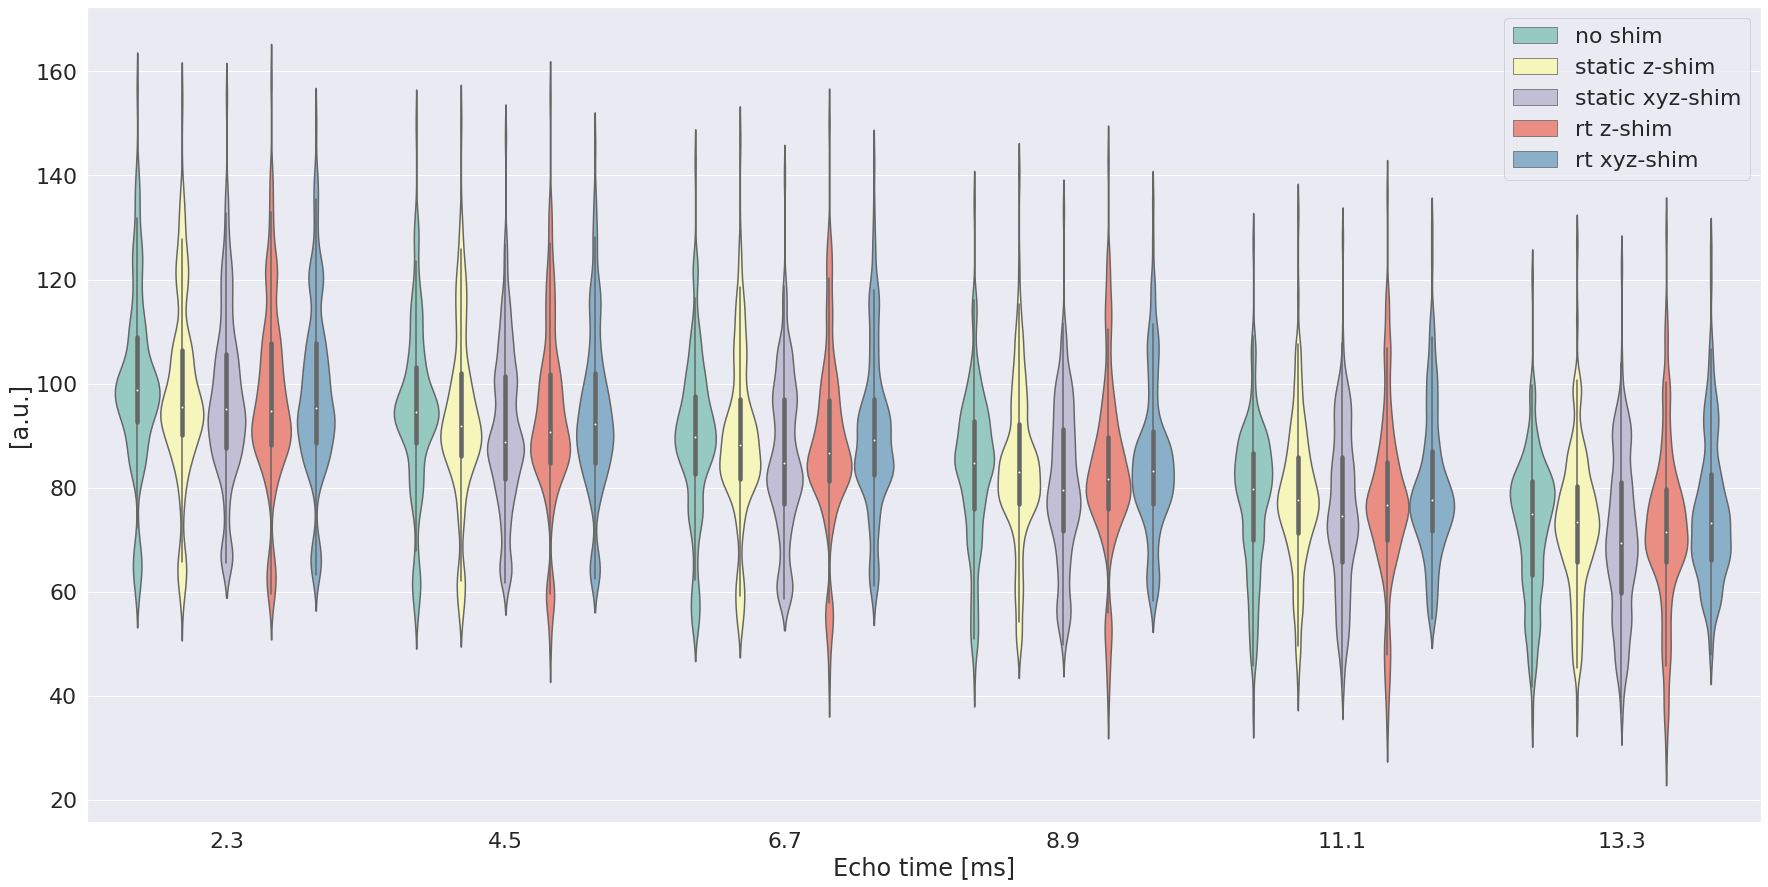

In [32]:
## Violin plot

A = np.concatenate((WA_matrix_noshim[...,None], WA_matrix_staticzshim[...,None]), axis=2)
B = np.concatenate((A, WA_matrix_staticshim[...,None]), axis=2)
C = np.concatenate((B, WA_matrix_rtzshim[...,None]), axis=2)
D = np.concatenate((C, WA_matrix_rtshim[...,None]), axis=2)

dim1, dim2, dim3 = np.meshgrid(np.arange(D.shape[0]), np.arange(D.shape[1]), np.arange(D.shape[2]), indexing='ij')
plt.figure(figsize=(30, 15))
sns.set(font_scale = 2)
ax = sns.violinplot(x=dim1.ravel(), y=D.ravel(), hue=dim3.ravel(), palette="Set3", bw=0.20)
ax.set_xticklabels(['2.3', '4.5', '6.7','8.9','11.1','13.3'])
ax.set_xlabel("Echo time [ms]")
ax.set_ylabel("[a.u.]")
ax.legend(handles=ax.legend_.legendHandles, labels=['no shim', 'static z-shim','static xyz-shim','rt z-shim','rt xyz-shim'])
plt.show()



##Visualisation: TE6 of the group-averaged, PAM50 registered MGRE scans

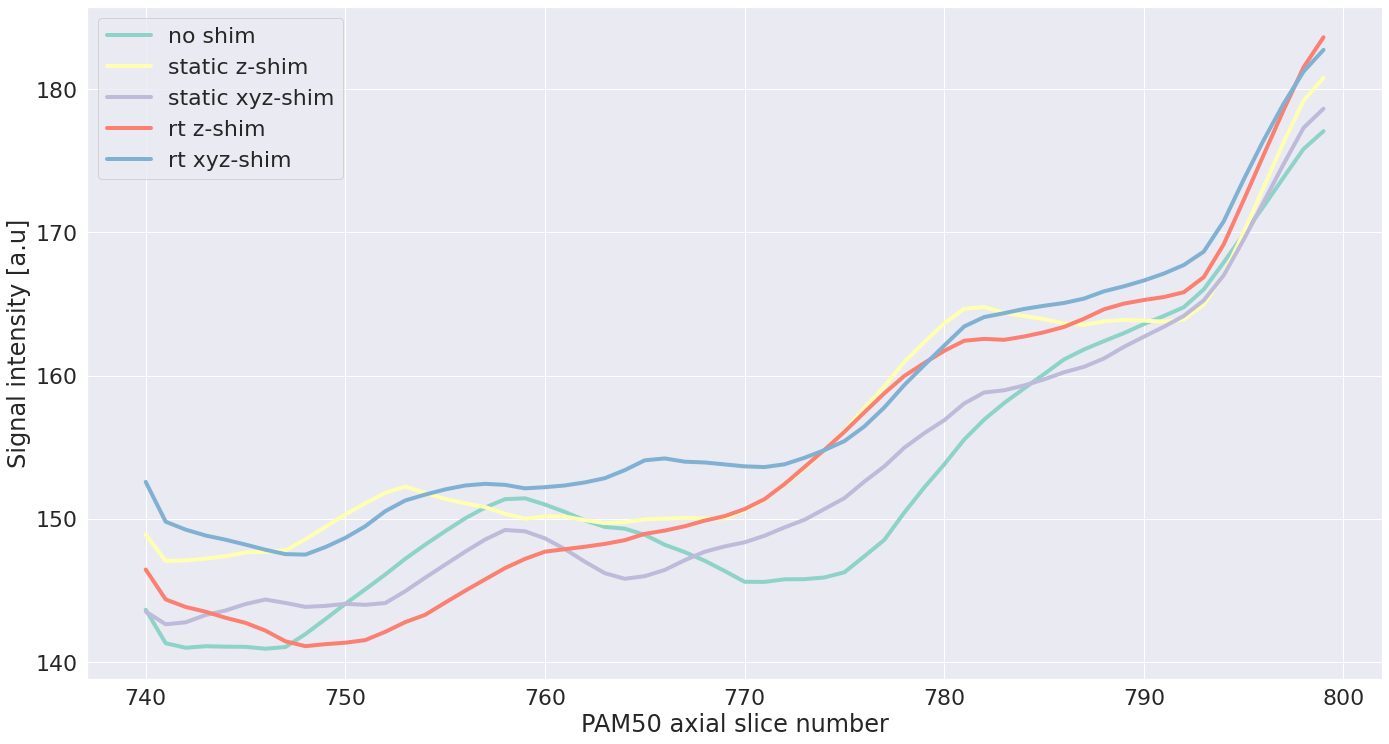

In [34]:

# Signal along the spinal cord for PAM50 registered TE6
csvfile_NOSHIM_mutual_coreg='/content/SC_rt_shim/PAM50_means/noshim_PAM50_sc.csv'
csvfile_staticSHIM_mutual_coreg='/content/SC_rt_shim/PAM50_means/staticshim_PAM50_sc.csv'
csvfile_staticzSHIM_mutual_coreg='/content/SC_rt_shim/PAM50_means/staticzshim_PAM50_sc.csv'
csvfile_rtSHIM_mutual_coreg='/content/SC_rt_shim/PAM50_means/rtshim_PAM50_sc.csv'
csvfile_rtzSHIM_mutual_coreg='/content/SC_rt_shim/PAM50_means/rtzshim_PAM50_sc.csv'

noshim_coreg_alongcord=signal_extractor_for_PAM50(csvfile_NOSHIM_mutual_coreg)
staticshim_coreg_alongcord=signal_extractor_for_PAM50(csvfile_staticSHIM_mutual_coreg)
staticzshim_coreg_alongcord=signal_extractor_for_PAM50(csvfile_staticzSHIM_mutual_coreg)
rtshim_coreg_alongcord=signal_extractor_for_PAM50(csvfile_rtSHIM_mutual_coreg)
rtzshim_coreg_alongcord=signal_extractor_for_PAM50(csvfile_rtzSHIM_mutual_coreg)

plt.clf()
plt.cla()
plt.close()
sns.set_style('darkgrid')
plt.figure(figsize=(20, 60))
TElist=['2.3', '4.5','6.7','8.9','11.1','13.3']
for subfig in range(5,6):
  plt.subplot(np.shape(noshim_coreg_alongcord)[0],1,subfig+1)
  plt.plot(noshim_coreg_alongcord[subfig,:], color=sns.color_palette("Set3")[0], linewidth=4) ##NOSHIM
  plt.plot(staticzshim_coreg_alongcord[subfig,:], color=sns.color_palette("Set3")[1], linewidth=4) ##STATICZ
  plt.plot(staticshim_coreg_alongcord[subfig,:], color=sns.color_palette("Set3")[2],linewidth=4) ##STATIC
  plt.plot(rtzshim_coreg_alongcord[subfig,:], color=sns.color_palette("Set3")[3], linewidth=4) ##RTZ
  plt.plot(rtshim_coreg_alongcord[subfig,:], color=sns.color_palette("Set3")[4], linewidth=4) ##RT
  #plt.title("Signal along the spinal cord for PAM50 coregistered scans at TE6")
  plt.xticks([0, 10, 20, 30, 40, 50, 60], ['740', '750', '760','770','780','790', '800'])
  plt.legend(["no shim","static z-shim","static xyz-shim","rt z-shim","rt xyz-shim"], loc='upper left')
  plt.xlabel('PAM50 axial slice number')
  plt.ylabel('Signal intensity [a.u]')
  #plt.rcParams["font.size"] = "60"
 
  #plt.tight_layout()

plt.tight_layout()

plt.rcParams.update({'font.size': 30})

#plt.rcParams["font.size"] = "20"

plt.show()

##Visualisation: Distribution of the STD of compensation gradients

In [35]:
#Extracting the required data 
Subjectdirs=sorted(glob.glob('/content/SC_rt_shim/'+'*acdc*')) 
Subjectdirs = [d for d in Subjectdirs if not len(glob.glob(d + '/Grad/*'))==0]
STD_XRIRO_for_all=np.zeros([len(Subjectdirs),12])
STD_YRIRO_for_all=np.zeros([len(Subjectdirs),12])
STD_ZRIRO_for_all=np.zeros([len(Subjectdirs),12])
STD_XSTATIC_for_all=np.zeros([len(Subjectdirs),12])
STD_YSTATIC_for_all=np.zeros([len(Subjectdirs),12])
STD_ZSTATIC_for_all=np.zeros([len(Subjectdirs),12])

for subject in range(len(Subjectdirs)):
  Anatdir = (Subjectdirs[subject]+ '/Anat/')
  Registrationdir=(Subjectdirs[subject]+ '/Anat/Registration/')
  Gradientdir= (Subjectdirs[subject]+ '/Grad/')
  # filenames
  XRIRO_CSV_name=(Gradientdir+'xriro_CSV.csv')
  YRIRO_CSV_name=(Gradientdir+'yriro_CSV.csv')
  ZRIRO_CSV_name=(Gradientdir+'zriro_CSV.csv')
  XSTATIC_CSV_name=(Gradientdir+'xstatic_CSV.csv')
  YSTATIC_CSV_name=(Gradientdir+'ystatic_CSV.csv')
  ZSTATIC_CSV_name=(Gradientdir+'zstatic_CSV.csv')
  STD_XRIRO_for_all[subject,:]=CoV_extractor_STD(XRIRO_CSV_name)
  STD_YRIRO_for_all[subject,:]=CoV_extractor_STD(YRIRO_CSV_name)
  STD_ZRIRO_for_all[subject,:]=CoV_extractor_STD(ZRIRO_CSV_name)
  STD_XSTATIC_for_all[subject,:]=CoV_extractor_STD(XSTATIC_CSV_name)
  STD_YSTATIC_for_all[subject,:]=CoV_extractor_STD(YSTATIC_CSV_name)
  STD_ZSTATIC_for_all[subject,:]=CoV_extractor_STD(ZSTATIC_CSV_name)

STD_XSTATIC_reshaped=np.reshape(STD_XSTATIC_for_all,np.shape(STD_XRIRO_for_all)[0]*np.shape(STD_XSTATIC_for_all)[1])
STD_YSTATIC_reshaped=np.reshape(STD_YSTATIC_for_all,np.shape(STD_XSTATIC_for_all)[0]*np.shape(STD_XSTATIC_for_all)[1])
STD_ZSTATIC_reshaped=np.reshape(STD_ZSTATIC_for_all,np.shape(STD_XSTATIC_for_all)[0]*np.shape(STD_XSTATIC_for_all)[1])


STD_XRIRO_reshaped=np.reshape(STD_XRIRO_for_all,np.shape(STD_XRIRO_for_all)[0]*np.shape(STD_XSTATIC_for_all)[1])
STD_YRIRO_reshaped=np.reshape(STD_YRIRO_for_all,np.shape(STD_XSTATIC_for_all)[0]*np.shape(STD_XSTATIC_for_all)[1])
STD_ZRIRO_reshaped=np.reshape(STD_ZRIRO_for_all,np.shape(STD_XSTATIC_for_all)[0]*np.shape(STD_XSTATIC_for_all)[1])


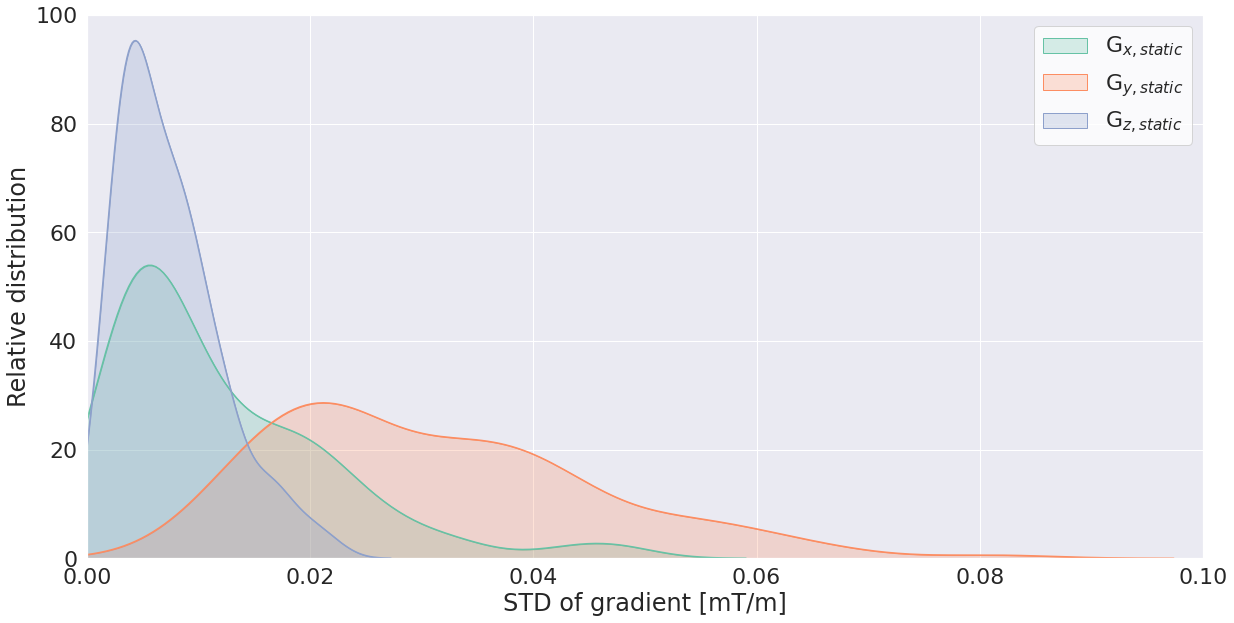

In [36]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.clf()
plt.cla()
plt.close()
plt.figure(figsize=(20, 10))
#sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
sns.set_style('darkgrid')


sns.kdeplot(STD_XSTATIC_reshaped, fill=True, color=sns.color_palette("Set2")[0])
sns.kdeplot(STD_YSTATIC_reshaped,fill=True,color=sns.color_palette("Set2")[1])
sns.kdeplot(STD_ZSTATIC_reshaped, fill=True, color=sns.color_palette("Set2")[2])
plt.xlabel('STD of compensation gradient [mT/m]')
plt.ylabel('Relative distribution')
plt.legend(['$\mathregular{G}_{x,static}$','$\mathregular{G}_{y,static}$','$\mathregular{G}_{z,static}$'], loc='upper right',facecolor='white')
ax=sns.kdeplot(STD_XSTATIC_reshaped,color=sns.color_palette("Set2")[0])
kde_x_ymax=np.max(ax.lines[0].get_ydata())
ax=sns.kdeplot(STD_YSTATIC_reshaped,color=sns.color_palette("Set2")[1])
kde_y_ymax=np.max(ax.lines[1].get_ydata())
ax=sns.kdeplot(STD_ZSTATIC_reshaped,color=sns.color_palette("Set2")[2])
kde_z_ymax=np.max(ax.lines[2].get_ydata())
maxyvalue=np.max([kde_x_ymax,kde_y_ymax,kde_z_ymax])

#plt.title('Distribution of the standard deviaton of the static compensation gradients for X, Y and Z')
plt.xlabel('STD of gradient [mT/m]')
plt.xlim(left=0, right=0.1)



plt.rcParams.update({'font.size': 30})
#g.despine(bottom=True, left=True)

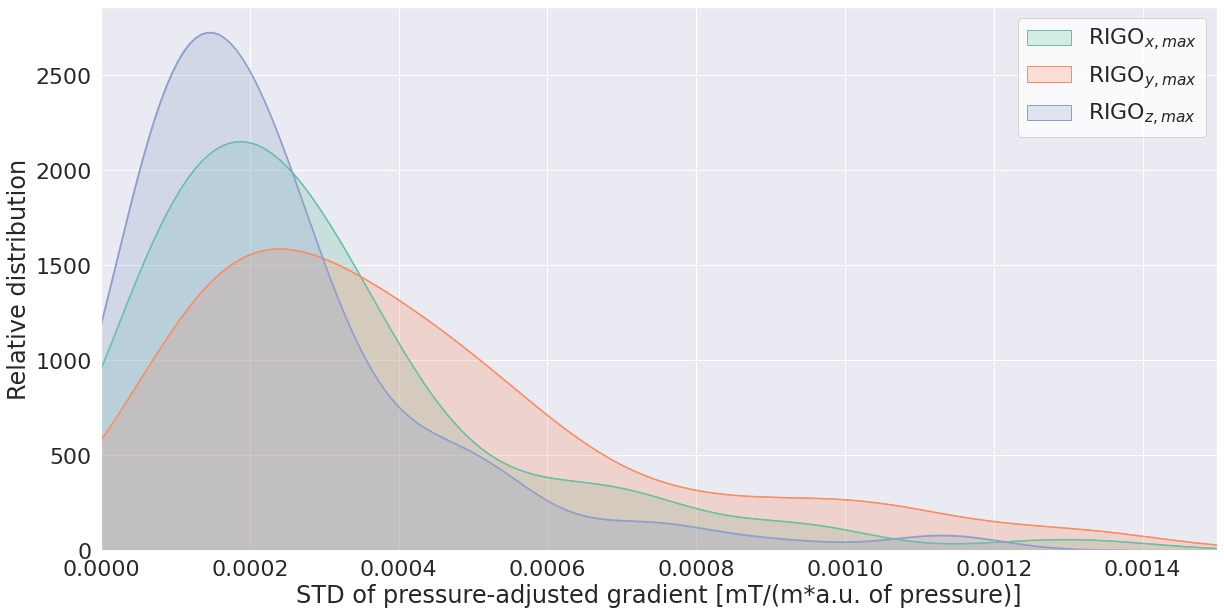

In [37]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.clf()
plt.cla()
plt.close()
plt.figure(figsize=(20, 10))
#sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
sns.kdeplot(STD_XRIRO_reshaped, fill=True, color=sns.color_palette("Set2")[0])
sns.kdeplot(STD_YRIRO_reshaped,fill=True,color=sns.color_palette("Set2")[1])
sns.kdeplot(STD_ZRIRO_reshaped, fill=True, color=sns.color_palette("Set2")[2])
plt.xlabel('STD of compensation gradient [mT/m]*pressure')
plt.ylabel('Relative distribution')
#plt.yticks([0, 600, 1200,1800,2400,3000], ['0', '20', '40','60','80','100'])
plt.legend(['$\mathregular{RIGO}_{x,max}$','$\mathregular{RIGO}_{y,max}$','$\mathregular{RIGO}_{z,max}$'], loc='upper right',facecolor='white')
#plt.title('Distribution of the standard deviaton of the RIGO compensation gradients for X, Y and Z')
ax=sns.kdeplot(STD_XRIRO_reshaped,color=sns.color_palette("Set2")[0])

ax=sns.kdeplot(STD_YRIRO_reshaped,color=sns.color_palette("Set2")[1])

ax=sns.kdeplot(STD_ZRIRO_reshaped,color=sns.color_palette("Set2")[2])

maxyvalue=np.max([kde_x_ymax,kde_y_ymax,kde_z_ymax])
plt.xlabel('STD of pressure-adjusted gradient [mT/(m*a.u. of pressure)]')
plt.xlim(left=0,right=0.0015)

plt.rcParams.update({'font.size': 30})
